In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import plotly.express as px
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [32]:
script_dir = Path('__file__').resolve().parent
data_path = script_dir.joinpath('data')

df_holidays = pd.read_csv(data_path.joinpath('holidays_events.csv'))
df_oil = pd.read_csv(data_path.joinpath('oil.csv'))
df_stores = pd.read_csv(data_path.joinpath('stores.csv'))
df_transactions = pd.read_csv(data_path.joinpath('transactions.csv'))
df_test = pd.read_csv(data_path.joinpath('test.csv'))
df_train = pd.read_csv(data_path.joinpath('train.csv'))

# Exploratory Analysis

In [33]:
df_train.info()
print(df_train.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
id       date        store_nbr  family                      sales  onpromotion
3000887  2017-08-15  9          SEAFOOD                     16.0   0              1
0        2013-01-01  1          AUTOMOTIVE                  0.0    0              1
1        2013-01-01  1          BABY CARE                   0.0    0              1
2        2013-01-01  1          BEAUTY                      0.0    0              1
3        2013-01-01  1          BEVERAGES                   0.0    0              1
                                                                                 ..
27       2013-01-01  1          P

# Holiday Analysis

In [34]:
df_holidays.info()
print(df_holidays.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
date        type        locale    locale_name  description                    transferred
2017-12-26  Additional  National  Ecuador      Navidad+1                      False          1
2012-03-02  Holiday     Local     Manta        Fundacion de Manta             False          1
2012-04-01  Holiday     Regional  Cotopaxi     Provincializacion de Cotopaxi  False          1
2012-04-12  Holiday     Local     Cuenca       Fundacion de Cuenca            False          1
2012-04-14  Holiday     Local     Libertad     C

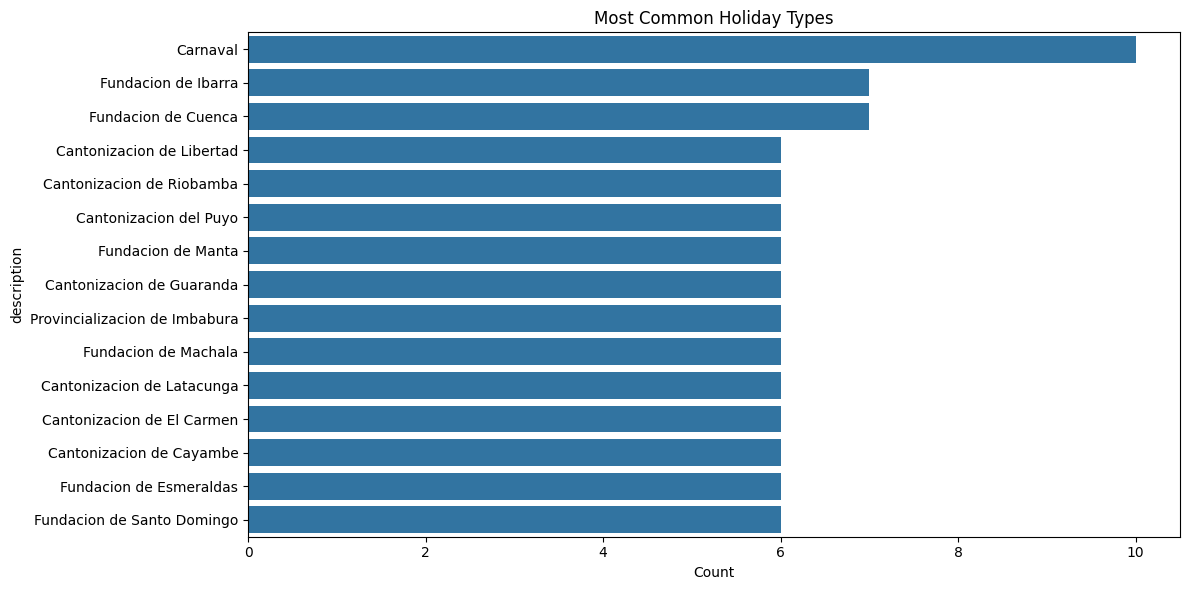

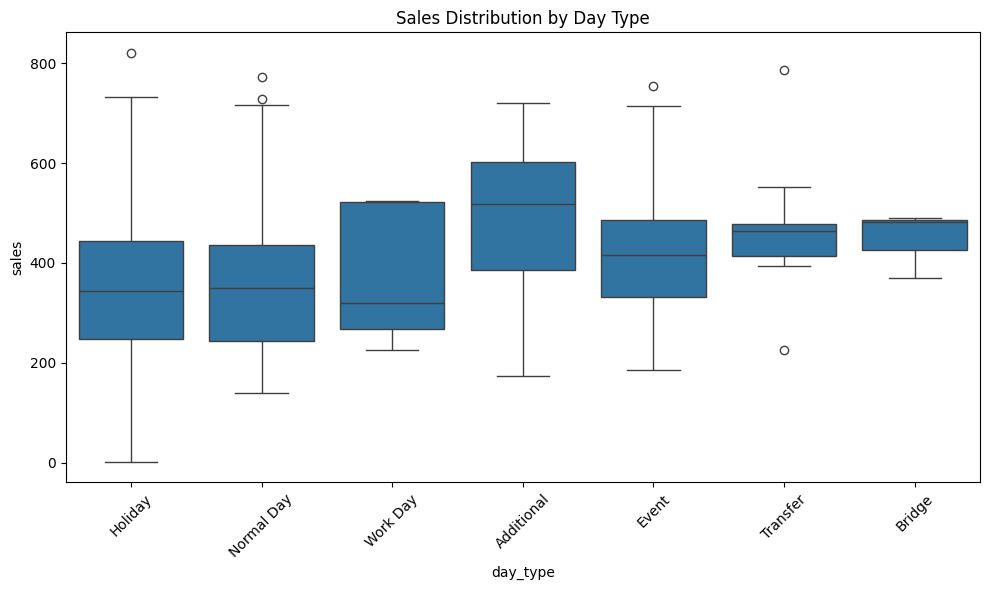

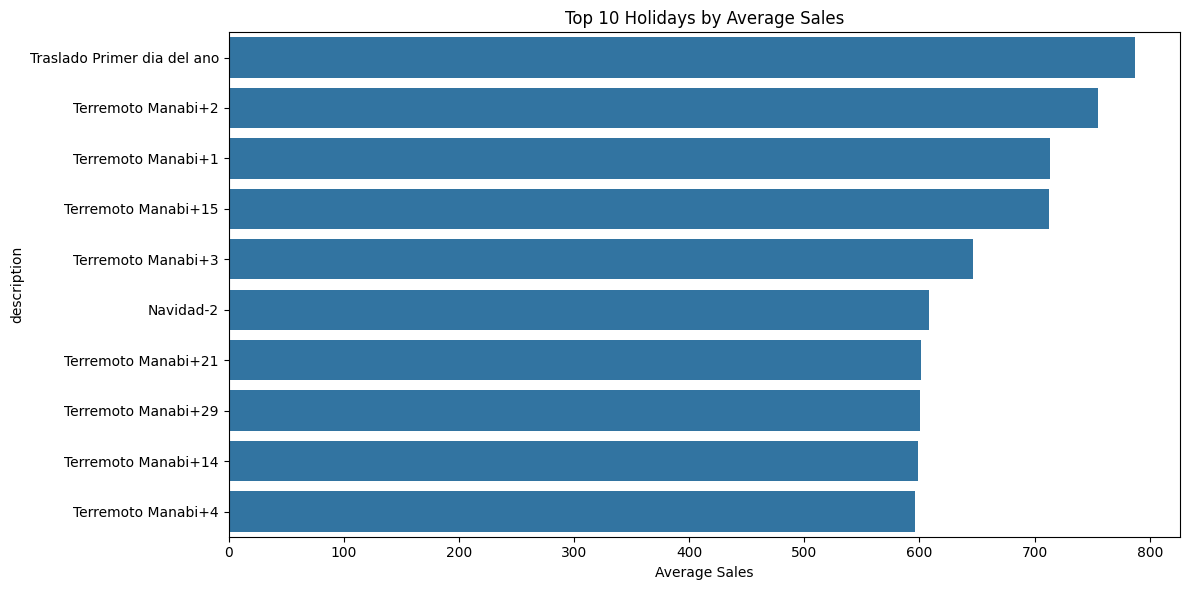

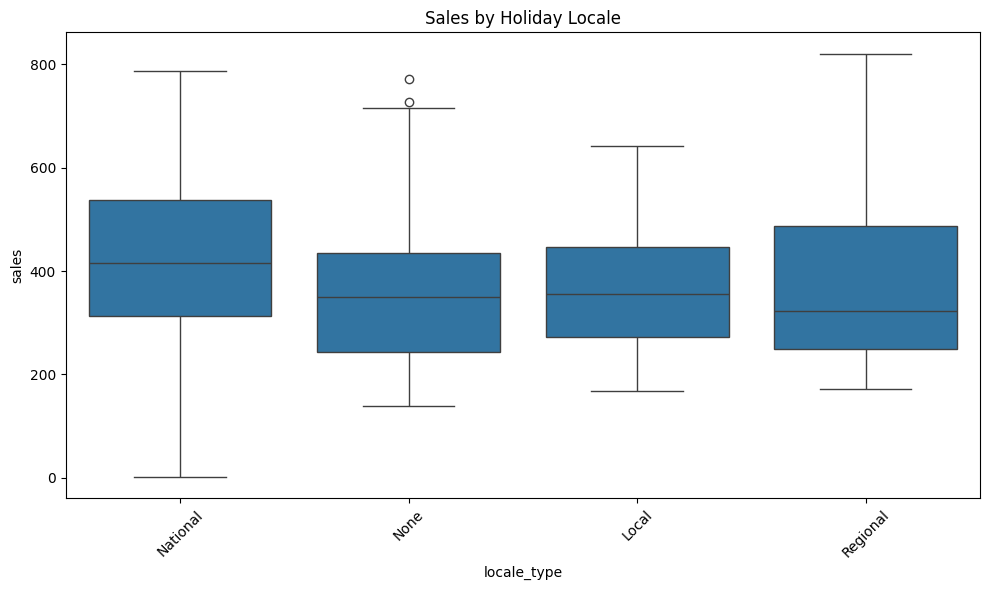

In [35]:
# Convert date to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Create a visualization of most common holiday descriptions
plt.figure(figsize=(12, 6))
top_holidays = df_holidays.description.value_counts().head(15)
sns.barplot(x=top_holidays.values, y=top_holidays.index)
plt.title('Most Common Holiday Types')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Group sales by date and calculate daily average
daily_sales = df_train.groupby('date')['sales'].mean().reset_index()

# Merge with holidays data to identify holiday dates
sales_with_holidays = pd.merge(daily_sales, df_holidays[['date', 'type', 'locale', 'description']], 
                              on='date', how='left')

# Create a day type category
sales_with_holidays['day_type'] = 'Normal Day'
sales_with_holidays.loc[~sales_with_holidays['type'].isna(), 'day_type'] = sales_with_holidays['type']

# Compare sales by day type
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_type', y='sales', data=sales_with_holidays)
plt.title('Sales Distribution by Day Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 holiday types by sales
holiday_sales = sales_with_holidays[~sales_with_holidays['description'].isna()]
top_holiday_sales = holiday_sales.groupby('description')['sales'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_holiday_sales.values, y=top_holiday_sales.index)
plt.title('Top 10 Holidays by Average Sales')
plt.xlabel('Average Sales')
plt.tight_layout()
plt.show()

# Compare National vs Local holidays
sales_with_holidays['locale_type'] = sales_with_holidays['locale'].fillna('None')
plt.figure(figsize=(10, 6))
sns.boxplot(x='locale_type', y='sales', data=sales_with_holidays)
plt.title('Sales by Holiday Locale')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

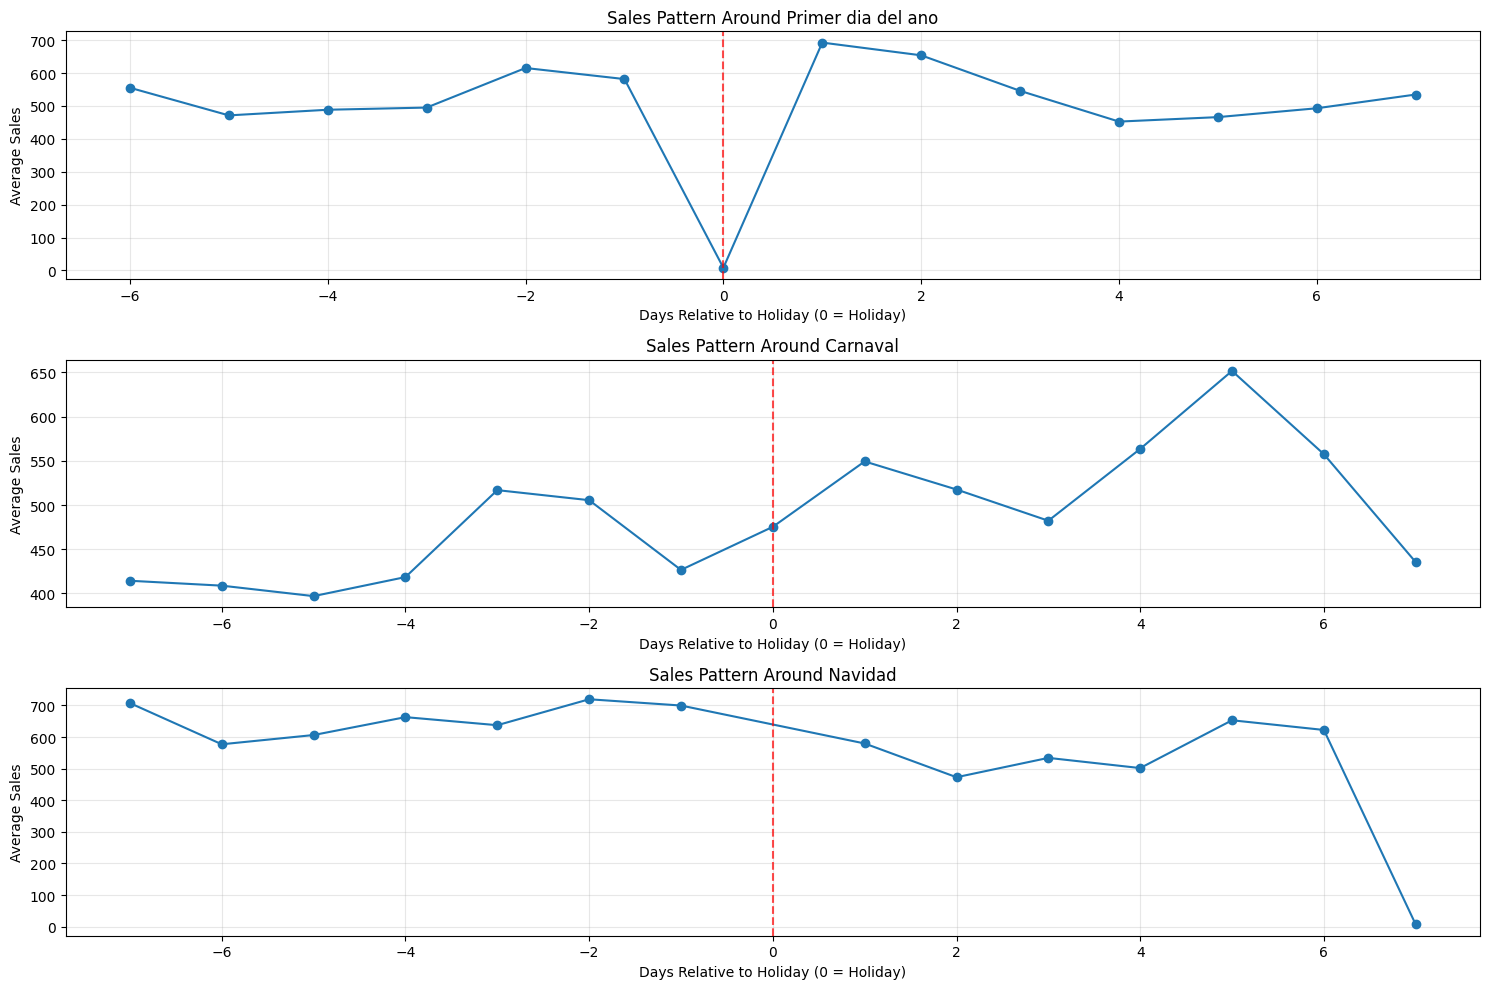

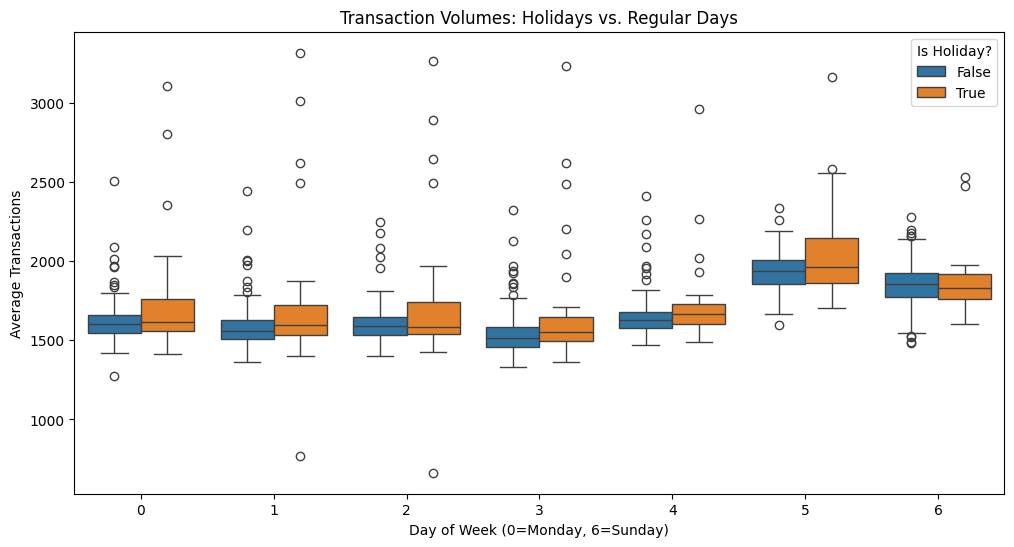

C:\Users\gupes\AppData\Local\Temp\ipykernel_14420\3324000853.py:126: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=holiday_effect, x='days_from_holiday', y='sales', hue='locale', ci=None)


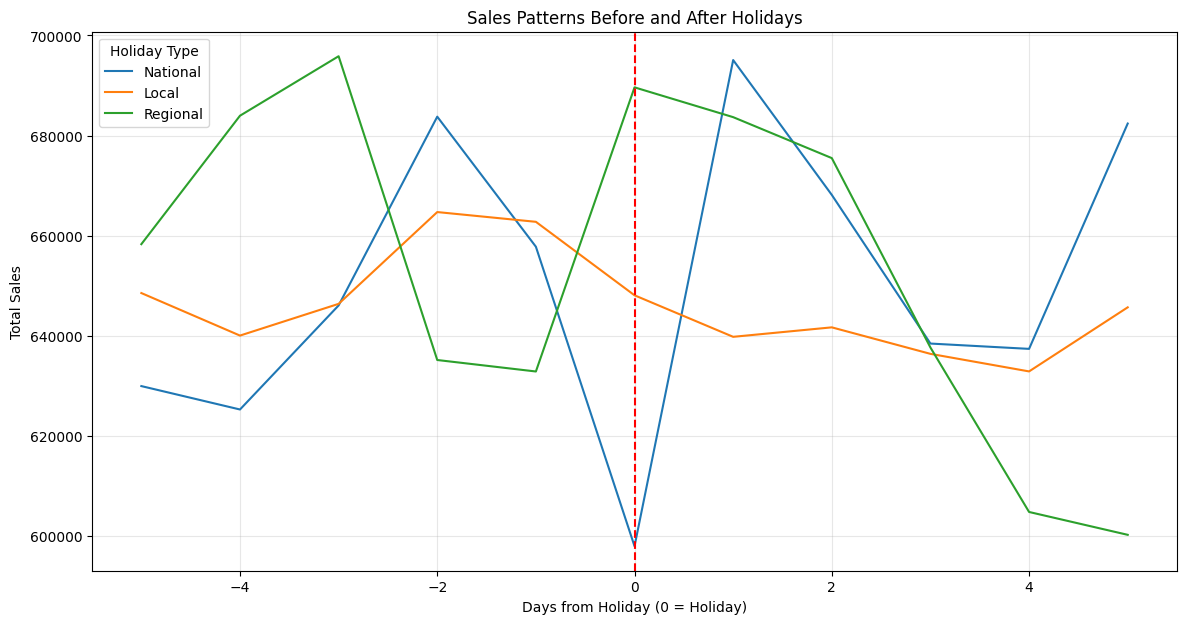

In [36]:
# Prepare data by converting transaction date to datetime
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

df_oil['date'] = pd.to_datetime(df_oil['date'])

# Create a function to analyze sales around holidays
def analyze_holiday_impact(holiday_date, days_before=7, days_after=7):
    """
    Analyzes sales before and after a holiday date
    Returns a DataFrame with daily sales for the period around the holiday
    """
    holiday_date = pd.to_datetime(holiday_date)
    start_date = holiday_date - pd.Timedelta(days=days_before)
    end_date = holiday_date + pd.Timedelta(days=days_after)
    
    # Get daily sales for the period
    mask = (daily_sales['date'] >= start_date) & (daily_sales['date'] <= end_date)
    period_sales = daily_sales[mask].copy()
    
    # Mark days relative to holiday
    period_sales['days_to_holiday'] = (period_sales['date'] - holiday_date).dt.days
    
    return period_sales

# Analyze major national holidays impact
national_holidays = df_holidays[df_holidays['locale'] == 'National'].copy()
major_holidays = national_holidays[~national_holidays['type'].isin(['Work Day', 'Additional', 'Transfer'])]

# Select a few important holidays for analysis
important_holidays = ['Primer dia del ano', 'Carnaval', 'Navidad']
holiday_dates = major_holidays[major_holidays['description'].isin(important_holidays)]['date'].unique()

# Create plot
plt.figure(figsize=(15, 10))

# Plot average sales patterns around holidays
for i, holiday_desc in enumerate(important_holidays):
    holiday_dates = major_holidays[major_holidays['description'] == holiday_desc]['date'].unique()
    
    # Get the most recent occurrence of each holiday (last 2 years)
    if len(holiday_dates) > 2:
        holiday_dates = sorted(holiday_dates)[-2:]
    
    avg_pattern = pd.DataFrame()
    
    for date in holiday_dates:
        impact_data = analyze_holiday_impact(date)
        if avg_pattern.empty:
            avg_pattern = impact_data.copy()
        else:
            # Combine data from multiple occurrences of the same holiday
            avg_pattern = pd.concat([
                avg_pattern, 
                impact_data[['days_to_holiday', 'sales']]
            ])
    
    # Group by days to holiday and calculate average
    avg_by_day = avg_pattern.groupby('days_to_holiday')['sales'].mean().reset_index()
    
    # Plot
    plt.subplot(3, 1, i+1)
    plt.plot(avg_by_day['days_to_holiday'], avg_by_day['sales'], marker='o')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.title(f'Sales Pattern Around {holiday_desc}')
    plt.xlabel('Days Relative to Holiday (0 = Holiday)')
    plt.ylabel('Average Sales')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare transaction volumes before/during/after holidays
# Merge transactions with holidays
df_transactions_holiday = pd.merge(
    df_transactions, 
    df_holidays[['date', 'type', 'locale', 'description']], 
    on='date', 
    how='left'
)

# Create holiday indicators (day before, holiday, day after)
df_transactions_holiday['holiday'] = ~df_transactions_holiday['type'].isna()
df_transactions_holiday['date'] = pd.to_datetime(df_transactions_holiday['date'])

# Add day of week
df_transactions_holiday['day_of_week'] = df_transactions_holiday['date'].dt.dayofweek

# Group by date and calculate averages
daily_transactions = df_transactions_holiday.groupby(['date', 'holiday', 'day_of_week'])['transactions'].mean().reset_index()

# Compare transactions on holidays vs non-holidays by day of week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='transactions', hue='holiday', data=daily_transactions)
plt.title('Transaction Volumes: Holidays vs. Regular Days')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Transactions')
plt.legend(title='Is Holiday?')
plt.show()

# Analyze preparation effect (increased sales before holidays)
# Calculate daily total sales and merge with holidays
total_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
total_daily_sales['date'] = pd.to_datetime(total_daily_sales['date'])
holidays_only = df_holidays[df_holidays['type'] == 'Holiday'].copy()

# Create a DataFrame with holiday and days before/after
holiday_effect = pd.DataFrame()

for _, holiday in holidays_only.iterrows():
    holiday_date = holiday['date']
    for days_delta in range(-5, 6):  # -5 to +5 days around holiday
        target_date = holiday_date + pd.Timedelta(days=days_delta)
        if target_date in total_daily_sales['date'].values:
            sales_row = total_daily_sales[total_daily_sales['date'] == target_date].iloc[0]
            new_row = pd.DataFrame({
                'date': [target_date],
                'days_from_holiday': [days_delta],
                'sales': [sales_row['sales']],
                'holiday_name': [holiday['description']],
                'locale': [holiday['locale']]
            })
            holiday_effect = pd.concat([holiday_effect, new_row], ignore_index=True)

# Plot the effect of days before/after holiday on sales
plt.figure(figsize=(14, 7))
sns.lineplot(data=holiday_effect, x='days_from_holiday', y='sales', hue='locale', ci=None)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Sales Patterns Before and After Holidays')
plt.xlabel('Days from Holiday (0 = Holiday)')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)
plt.legend(title='Holiday Type')
plt.show()

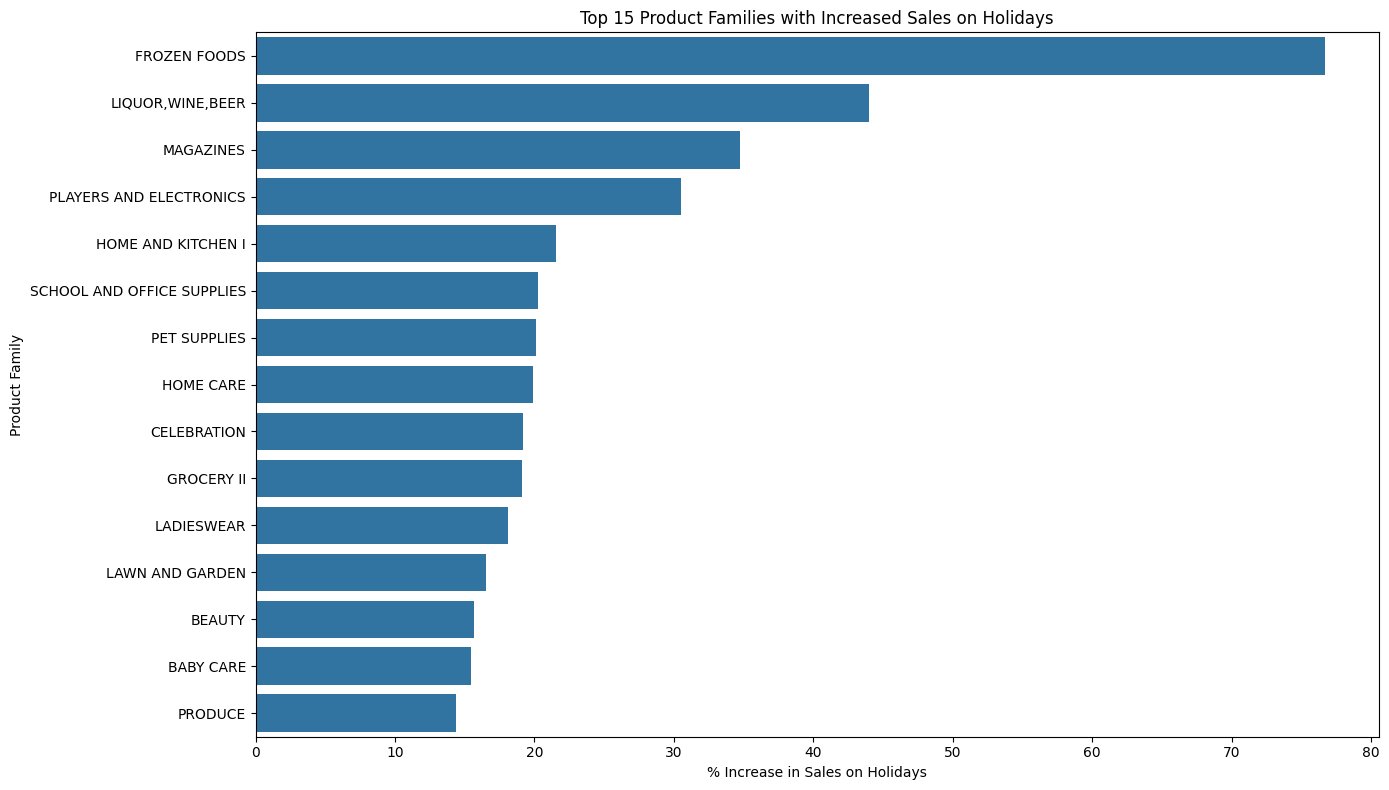

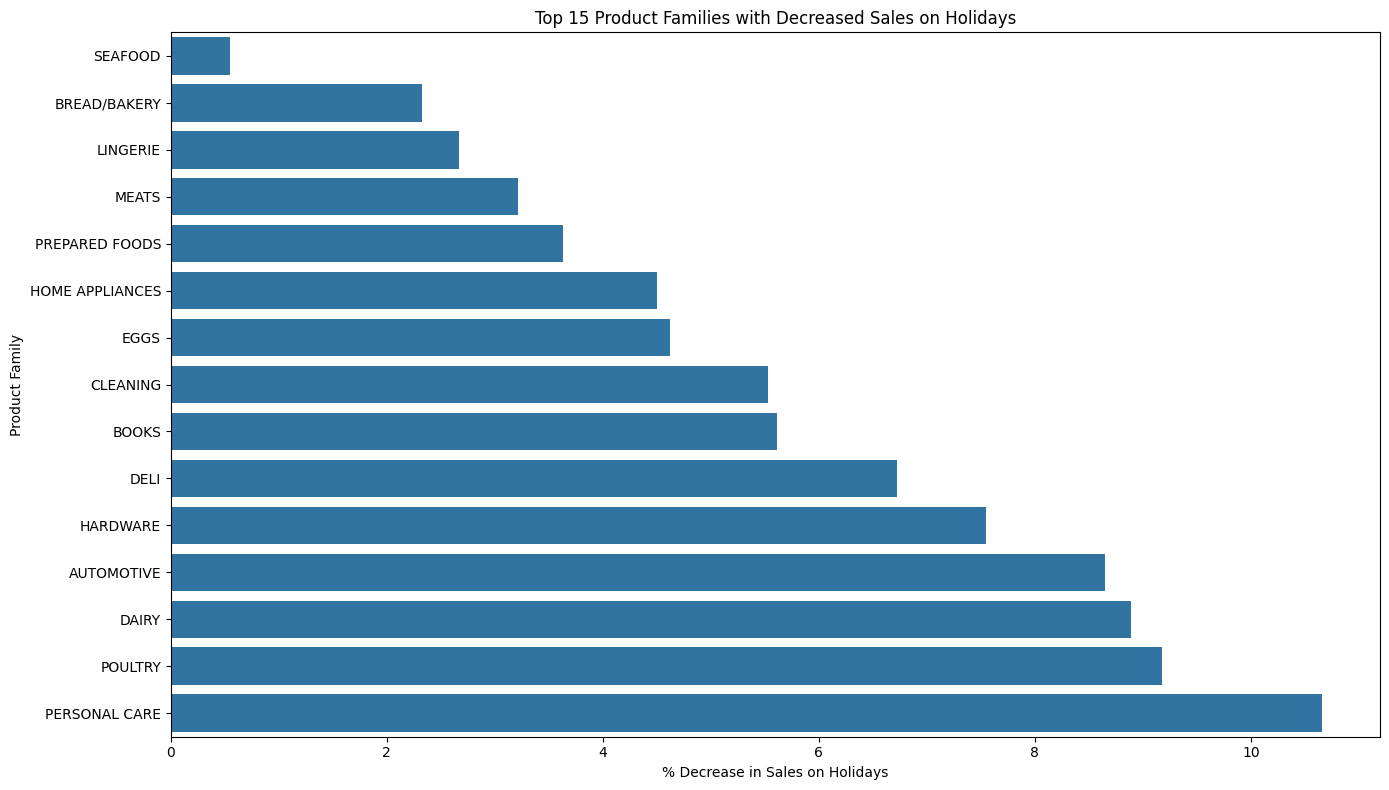

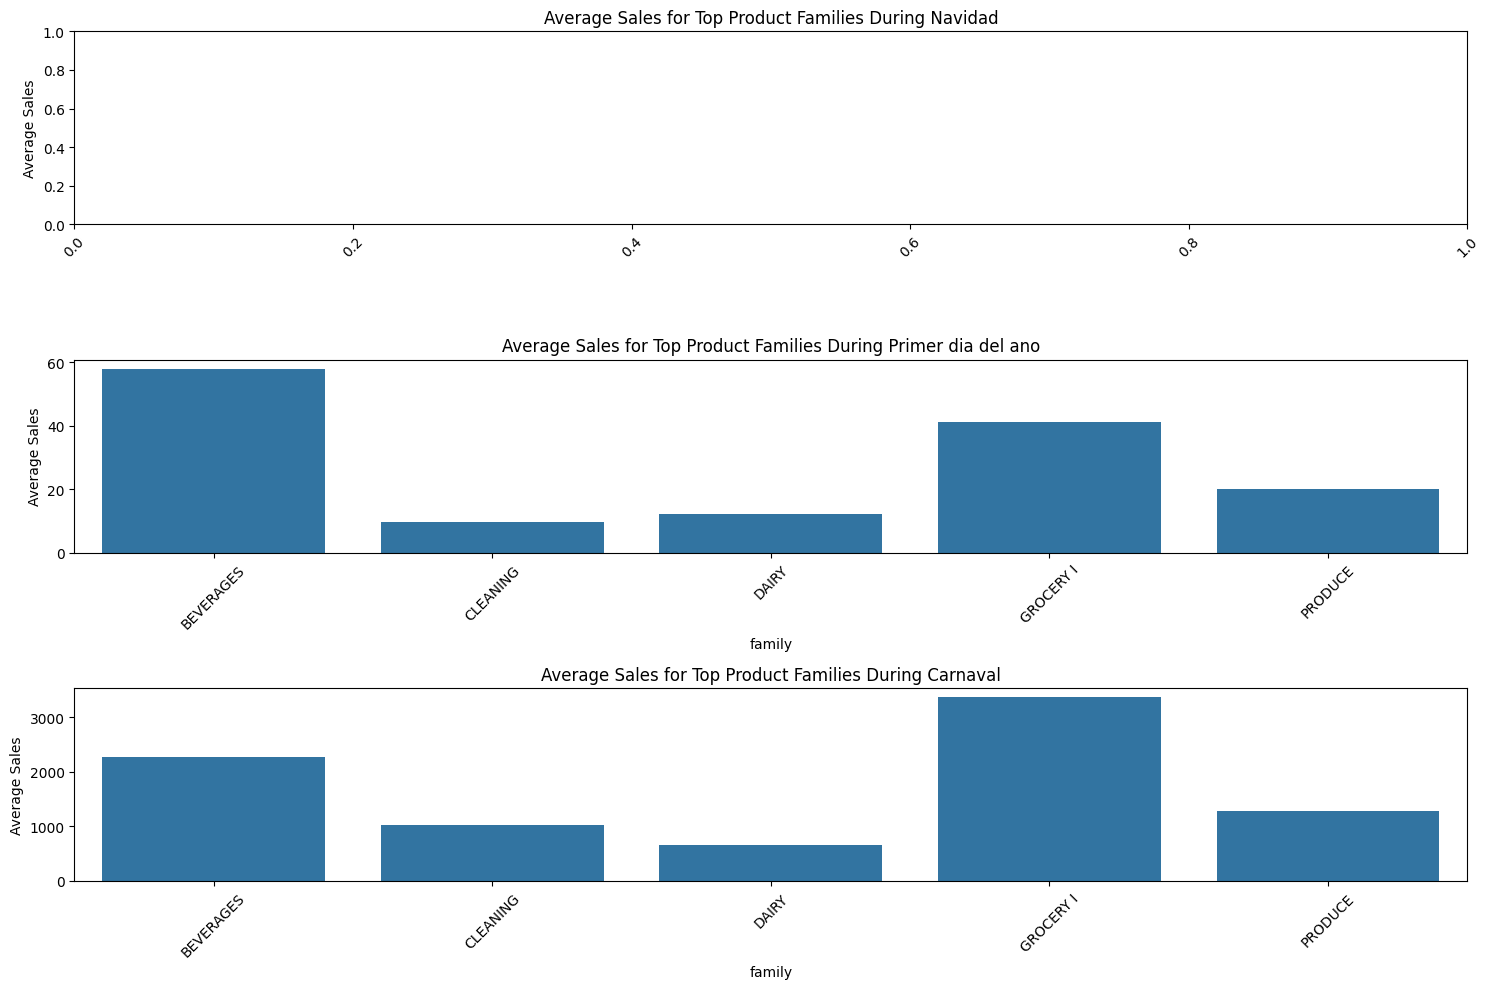

Top 10 Product Families Most Positively Affected by Holidays:
                       family  non_holiday_sales  holiday_sales  pct_change
0                FROZEN FOODS         140.513014     248.315581   76.720700
1            LIQUOR,WINE,BEER          79.964825     115.159706   44.012953
2                   MAGAZINES           2.799607       3.773181   34.775387
3     PLAYERS AND ELECTRONICS           5.936892       7.748555   30.515344
4          HOME AND KITCHEN I          19.877845      24.163515   21.560031
5  SCHOOL AND OFFICE SUPPLIES           2.869776       3.451537   20.272009
6                PET SUPPLIES           3.823790       4.591608   20.080027
7                   HOME CARE         171.673456     205.828540   19.895378
8                 CELEBRATION           8.164455       9.729511   19.169143
9                  GROCERY II          21.002897      25.010113   19.079350

Top 10 Product Families Most Negatively Affected by Holidays:
             family  non_holiday_sales 

In [37]:
# Check impact of holidays on different product families
# First, merge train data with holidays to identify holiday dates
train_with_holidays = pd.merge(df_train, df_holidays[['date', 'type', 'locale', 'description']], 
                              on='date', how='left')

# Create holiday flagf
train_with_holidays['is_holiday'] = ~train_with_holidays['type'].isna()

# Calculate average sales by family for holiday vs non-holiday
family_holiday_impact = train_with_holidays.groupby(['family', 'is_holiday'])['sales'].mean().reset_index()

# Pivot to compare holiday vs non-holiday for each family
family_impact_pivot = family_holiday_impact.pivot(index='family', 
                                                columns='is_holiday', 
                                                values='sales').reset_index()
family_impact_pivot.columns = ['family', 'non_holiday_sales', 'holiday_sales']

# Calculate percentage difference
family_impact_pivot['pct_change'] = ((family_impact_pivot['holiday_sales'] - 
                                     family_impact_pivot['non_holiday_sales']) / 
                                     family_impact_pivot['non_holiday_sales'] * 100)

# Sort by percentage difference to see most affected families
family_impact_sorted = family_impact_pivot.sort_values('pct_change', ascending=False).reset_index(drop=True)

# Plot top 15 most positively affected families
plt.figure(figsize=(14, 8))
top_families = family_impact_sorted.head(15)
sns.barplot(y='family', x='pct_change', data=top_families)
plt.title('Top 15 Product Families with Increased Sales on Holidays')
plt.xlabel('% Increase in Sales on Holidays')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

# Plot bottom 15 most negatively affected families
plt.figure(figsize=(14, 8))
bottom_families = family_impact_sorted.tail(15).iloc[::-1]
sns.barplot(y='family', x='pct_change', data=bottom_families)
plt.title('Top 15 Product Families with Decreased Sales on Holidays')
plt.xlabel('% Decrease in Sales on Holidays')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

# Look at specific holiday types and their impact on top product families
# Focus on major holidays like Christmas, New Year, and Carnival
major_holiday_names = ['Navidad', 'Primer dia del ano', 'Carnaval']
major_holidays_data = train_with_holidays[train_with_holidays['description'].isin(major_holiday_names)]

# Top 5 families by sales overall
top_families_overall = df_train.groupby('family')['sales'].sum().sort_values(ascending=False).head(5).index

# Create a plot showing sales for top families during major holidays
plt.figure(figsize=(15, 10))

for i, holiday in enumerate(major_holiday_names):
    plt.subplot(3, 1, i+1)
    holiday_data = major_holidays_data[major_holidays_data['description'] == holiday]
    
    # Aggregate sales by family for this holiday
    family_sales = holiday_data[holiday_data['family'].isin(top_families_overall)].groupby('family')['sales'].mean()
    
    sns.barplot(x=family_sales.index, y=family_sales.values)
    plt.title(f'Average Sales for Top Product Families During {holiday}')
    plt.ylabel('Average Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Top 10 Product Families Most Positively Affected by Holidays:")
print(family_impact_sorted[['family', 'non_holiday_sales', 'holiday_sales', 'pct_change']].head(10))
print("\nTop 10 Product Families Most Negatively Affected by Holidays:")
print(family_impact_sorted[['family', 'non_holiday_sales', 'holiday_sales', 'pct_change']].tail(10).iloc[::-1])

In [38]:
# Merge train data with holidays data
df_train = pd.merge(
    df_train,
    df_holidays[['date', 'type', 'locale', 'description', 'transferred']],
    on='date',
    how='left'
)
# Display first few rows to check the merge
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Primer dia del ano,False


## Holiday Feature Engineering

In [39]:
df_train['is_national_holiday'] = df_train['type'].apply(lambda x: 1 if x == 'National' else 0)
df_train['is_regional_holiday'] = df_train['type'].apply(lambda x: 1 if x == 'Regional' else 0)
df_train['is_local_holiday'] = df_train['type'].apply(lambda x: 1 if x == 'Local' else 0)
df_train['is_transferred'] = df_train['transferred'].apply(lambda x: 1 if x else 0)

In [40]:
# Create columns for holiday proximity (4 days before and 4 days after)
for days_shift in range(-4, 5):
    if days_shift == 0:  # Skip the actual holiday day (already captured in existing columns)
        continue
        
    # Create column name based on sign (holiday-1, holiday+2, etc)
    sign = "+" if days_shift > 0 else ""
    col_name = f"holiday{sign}{days_shift}"
    
    # Initialize columns with zeros
    df_train[col_name] = 0
    df_test[col_name] = 0

# Fill in the proximity values
holiday_dates = df_holidays[df_holidays['type'] == 'Holiday']['date'].unique()

# For train dataset
for holiday_date in holiday_dates:
    for days_shift in range(-4, 5):
        if days_shift == 0:
            continue
            
        target_date = holiday_date + pd.Timedelta(days=days_shift)
        sign = "+" if days_shift > 0 else ""
        col_name = f"holiday{sign}{days_shift}"
        
        # Set 1 for rows that match the target date
        df_train.loc[df_train['date'] == target_date, col_name] = 1

# For test dataset
for holiday_date in holiday_dates:
    for days_shift in range(-4, 5):
        if days_shift == 0:
            continue
            
        target_date = holiday_date + pd.Timedelta(days=days_shift)
        sign = "+" if days_shift > 0 else ""
        col_name = f"holiday{sign}{days_shift}"
        
        # Set 1 for rows that match the target date
        df_test.loc[df_test['date'] == target_date, col_name] = 1

# Display first few rows with new columns to verify
print("Train data with holiday proximity columns:")
print(df_train[['date', 'is_national_holiday', 'is_regional_holiday', 'is_local_holiday', 
               'holiday-4', 'holiday-3', 'holiday-2', 'holiday-1',
               'holiday+1', 'holiday+2', 'holiday+3', 'holiday+4']].sample(5))

Train data with holiday proximity columns:
              date  is_national_holiday  is_regional_holiday  \
780133  2014-03-10                    0                    0   
740418  2014-02-16                    0                    0   
975992  2014-06-25                    0                    0   
2652389 2017-01-06                    0                    0   
1523095 2015-04-26                    0                    0   

         is_local_holiday  holiday-4  holiday-3  holiday-2  holiday-1  \
780133                  0          0          0          0          0   
740418                  0          0          0          0          0   
975992                  0          0          0          0          0   
2652389                 0          0          0          0          0   
1523095                 0          0          0          0          0   

         holiday+1  holiday+2  holiday+3  holiday+4  
780133           0          0          0          0  
740418           0       

# Store Analysis

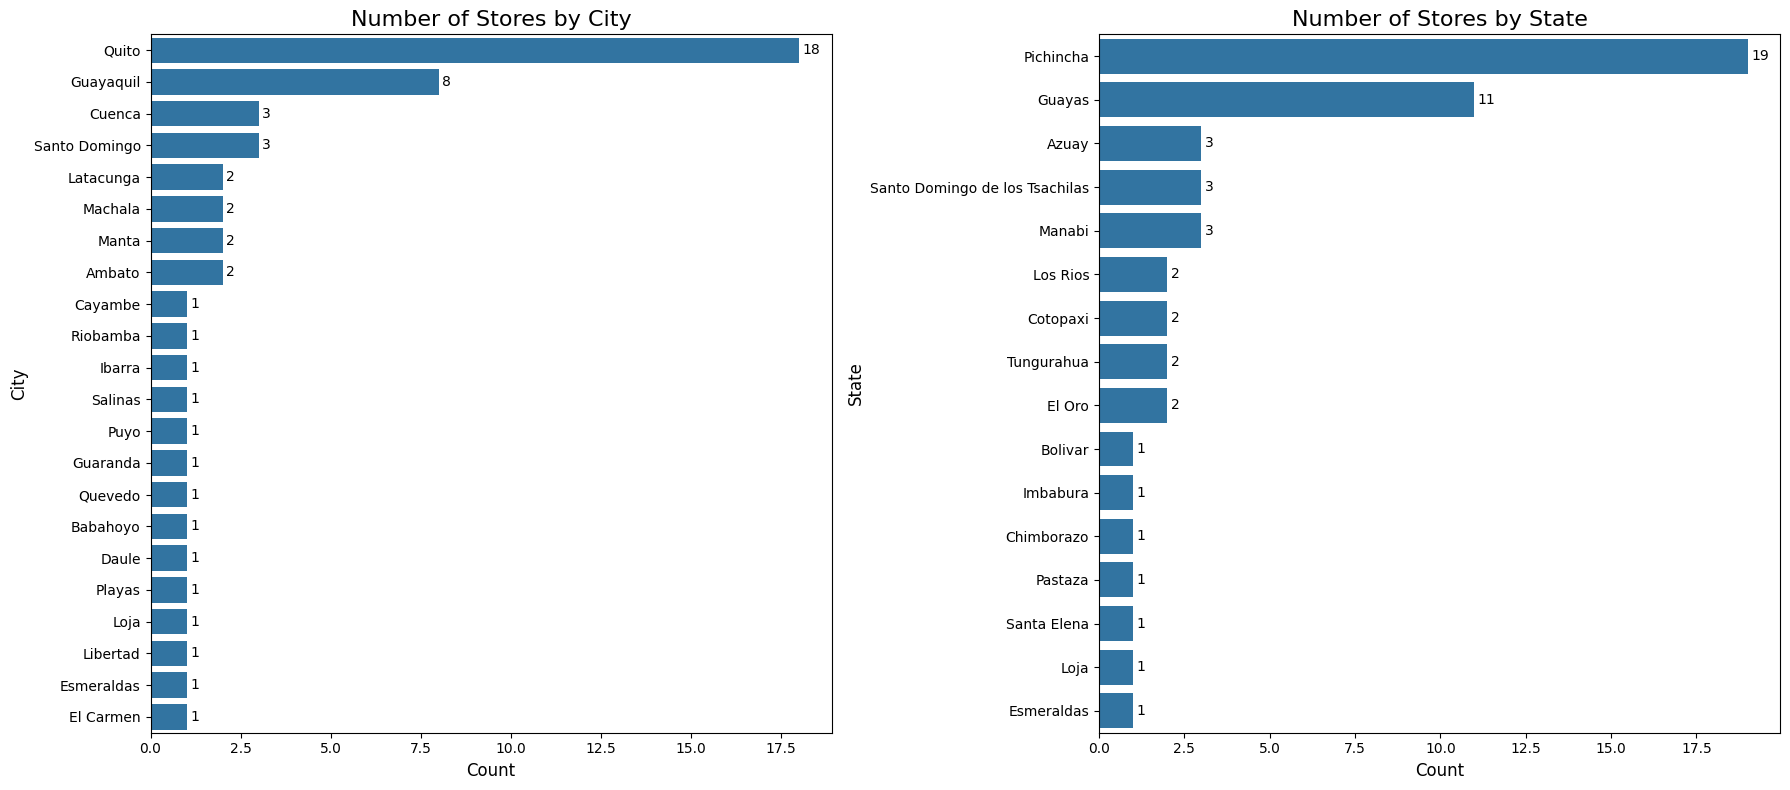


Store Count by City:
city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Latacunga         2
Machala           2
Manta             2
Ambato            2
Cayambe           1
Riobamba          1
Ibarra            1
Salinas           1
Puyo              1
Guaranda          1
Quevedo           1
Babahoyo          1
Daule             1
Playas            1
Loja              1
Libertad          1
Esmeraldas        1
El Carmen         1
Name: count, dtype: int64

Store Count by State:
state
Pichincha                         19
Guayas                            11
Azuay                              3
Santo Domingo de los Tsachilas     3
Manabi                             3
Los Rios                           2
Cotopaxi                           2
Tungurahua                         2
El Oro                             2
Bolivar                            1
Imbabura                           1
Chimborazo                         1
Pastaza                           

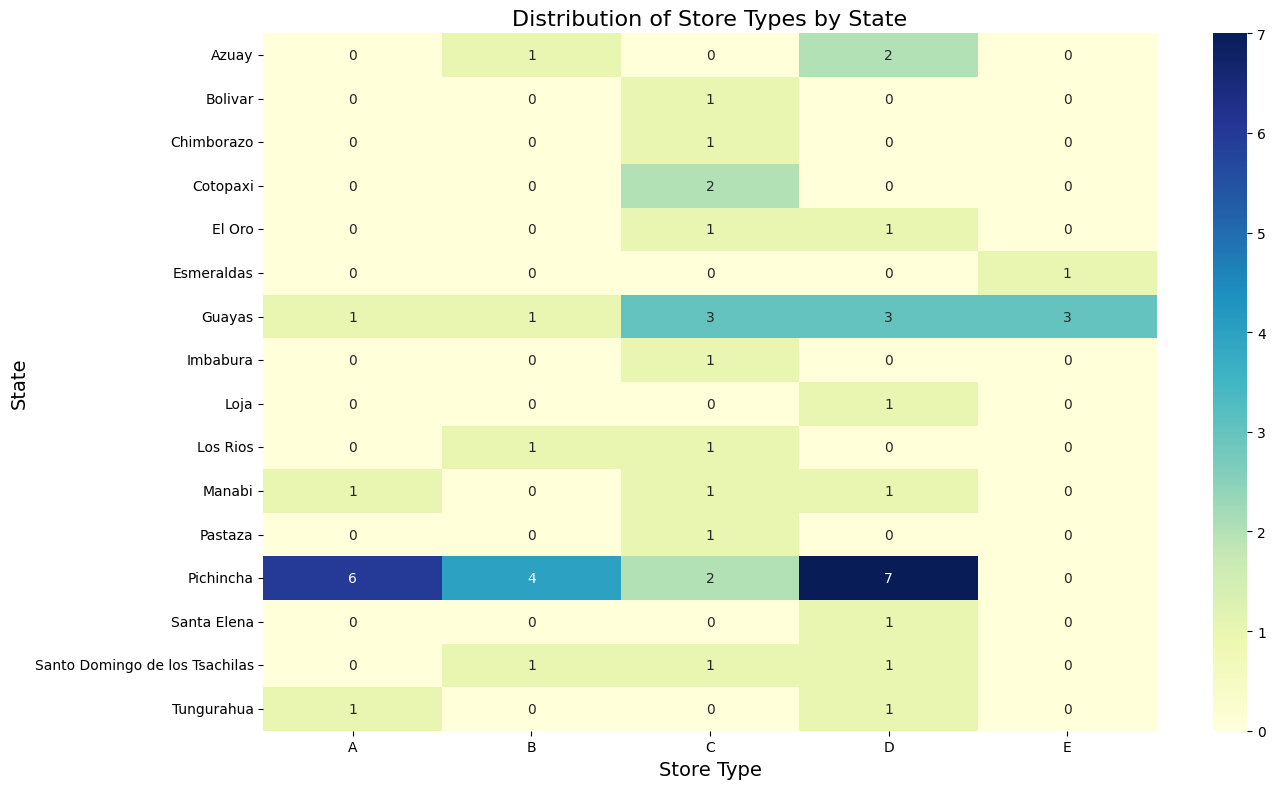

In [41]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Count stores by city
city_counts = df_stores['city'].value_counts().sort_values(ascending=False)
city_plot = sns.barplot(x=city_counts.values, y=city_counts.index, ax=ax1)
ax1.set_title('Number of Stores by City', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('City', fontsize=12)

# Add count numbers to the city bars
for i, v in enumerate(city_counts.values):
    ax1.text(v + 0.1, i, str(v), va='center')

# Count stores by state
state_counts = df_stores['state'].value_counts().sort_values(ascending=False)
state_plot = sns.barplot(x=state_counts.values, y=state_counts.index, ax=ax2)
ax2.set_title('Number of Stores by State', fontsize=16)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('State', fontsize=12)

# Add count numbers to the state bars
for i, v in enumerate(state_counts.values):
    ax2.text(v + 0.1, i, str(v), va='center')

plt.tight_layout()
plt.show()

# Display the numerical data as well
print("\nStore Count by City:")
print(city_counts)

print("\nStore Count by State:")
print(state_counts)

# Create a choropleth-style heatmap of store types by state
store_type_by_state = pd.crosstab(df_stores['state'], df_stores['type'])
plt.figure(figsize=(14, 8))
sns.heatmap(store_type_by_state, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Distribution of Store Types by State', fontsize=16)
plt.ylabel('State', fontsize=14)
plt.xlabel('Store Type', fontsize=14)
plt.tight_layout()
plt.show()

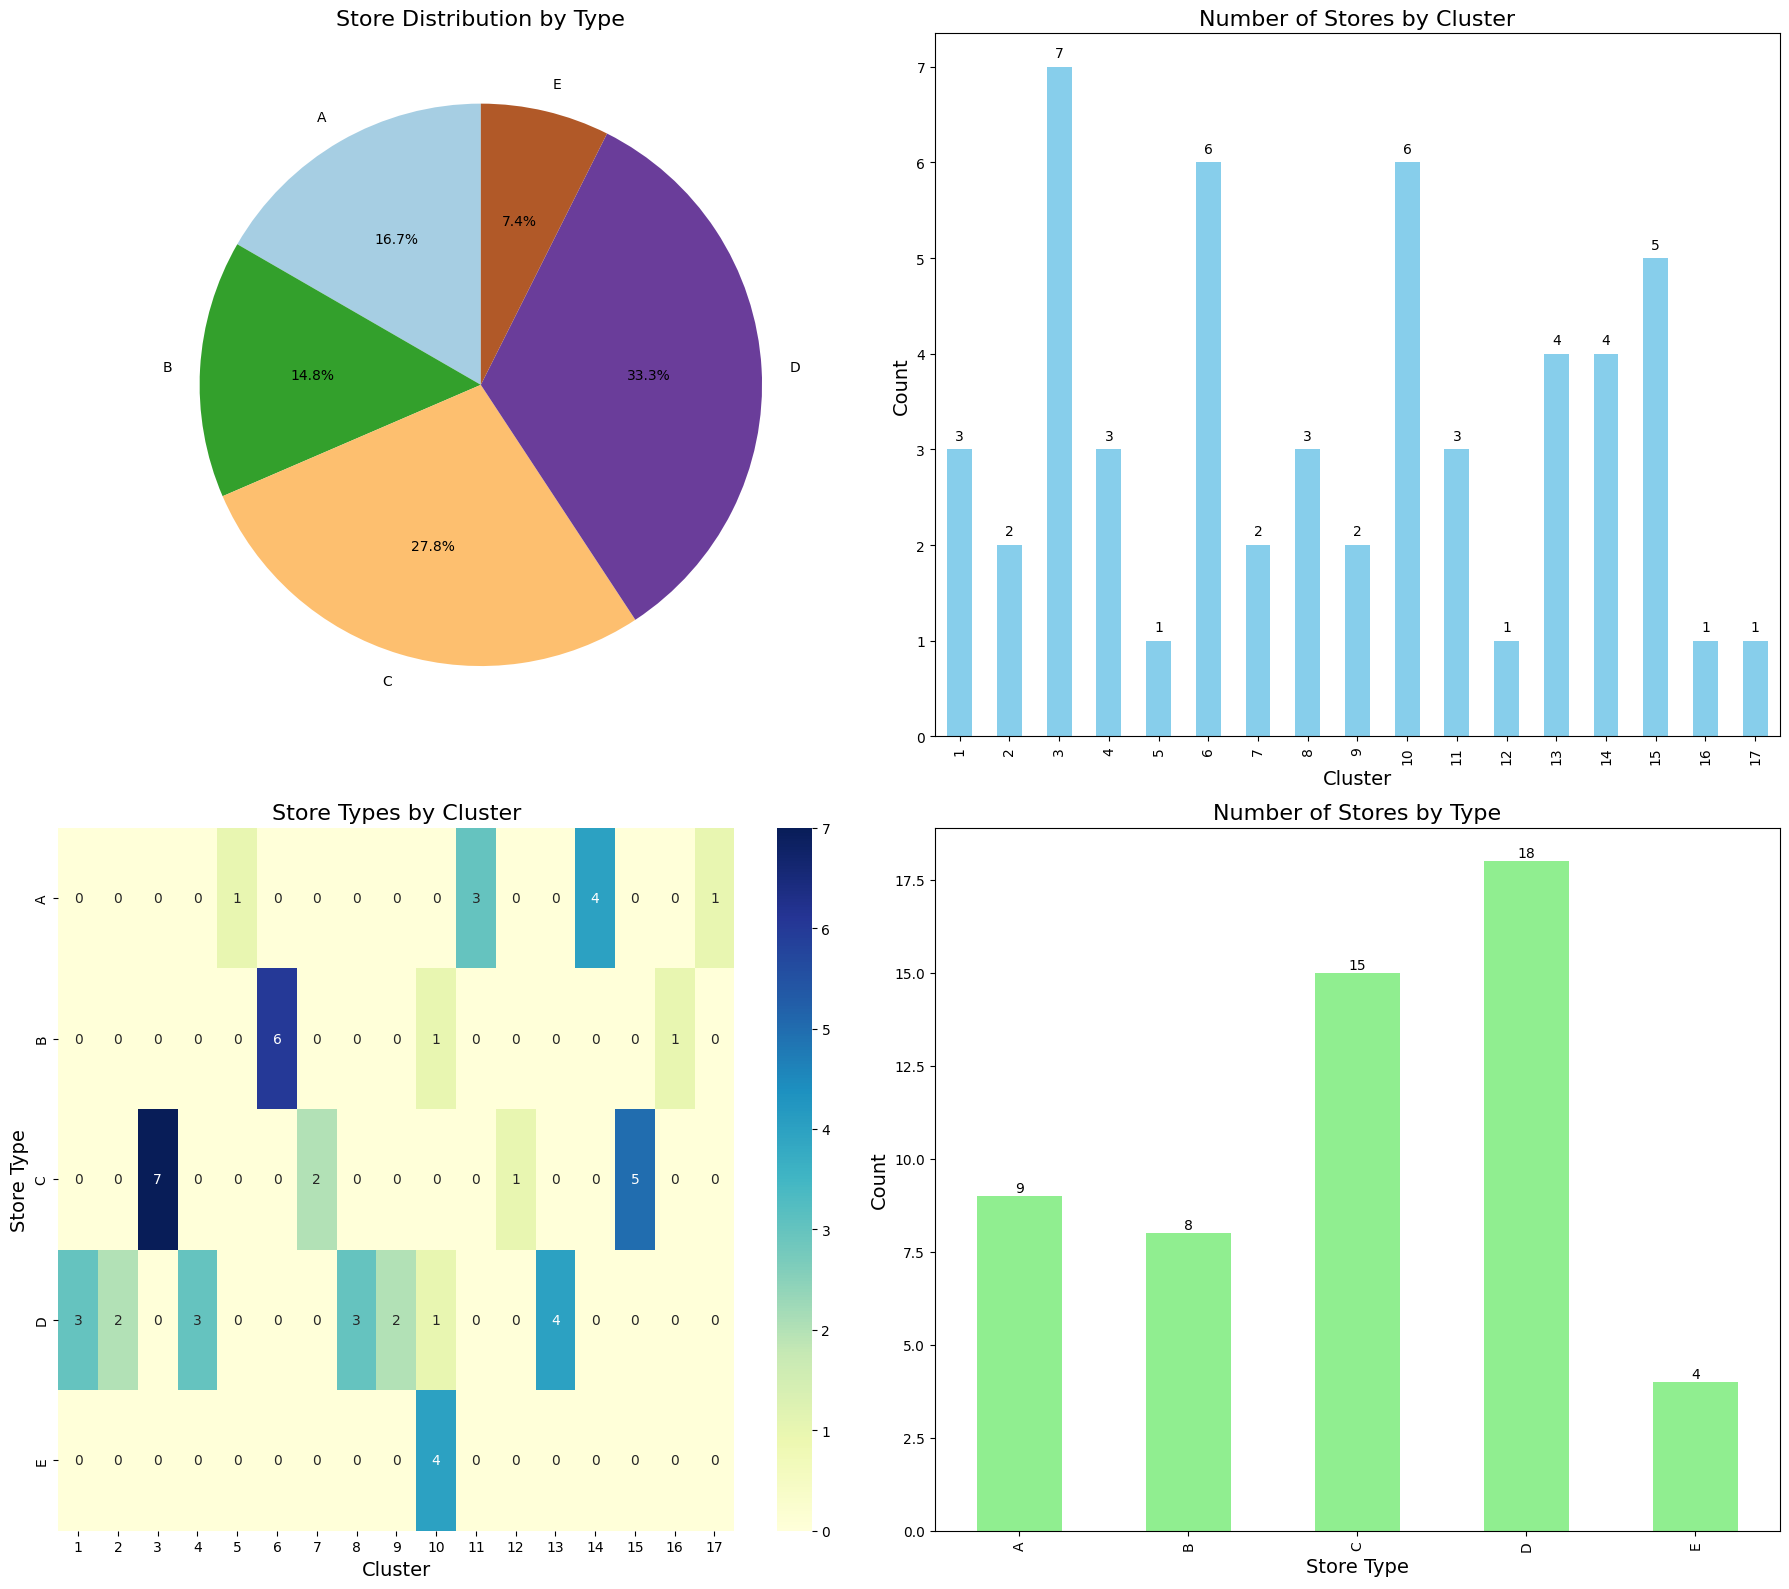

Store Count by Type:
type
A     9
B     8
C    15
D    18
E     4
Name: count, dtype: int64

Store Count by Cluster:
cluster
1     3
2     2
3     7
4     3
5     1
6     6
7     2
8     3
9     2
10    6
11    3
12    1
13    4
14    4
15    5
16    1
17    1
Name: count, dtype: int64

Summary Statistics:
Total number of stores: 54
Most common store type: D (18 stores)
Most common cluster: Cluster 3 (7 stores)
Number of unique clusters: 17


In [42]:
# Create a figure with multiple subplots for different visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Count stores by type
store_type_counts = df_stores['type'].value_counts().sort_index()
type_ax = axes[0, 0]
store_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=type_ax, 
                      colors=plt.cm.Paired(np.linspace(0, 1, len(store_type_counts))))
type_ax.set_title('Store Distribution by Type', fontsize=16)
type_ax.set_ylabel('')  # Remove y-label for pie chart

# Count stores by cluster
store_cluster_counts = df_stores['cluster'].value_counts().sort_index()
cluster_ax = axes[0, 1]
store_cluster_counts.plot(kind='bar', ax=cluster_ax, color='skyblue')
cluster_ax.set_title('Number of Stores by Cluster', fontsize=16)
cluster_ax.set_xlabel('Cluster', fontsize=14)
cluster_ax.set_ylabel('Count', fontsize=14)
# Add count labels to the bars
for i, v in enumerate(store_cluster_counts):
    cluster_ax.text(i, v + 0.1, str(v), ha='center')

# Create cross-tabulation of type and cluster to see their relationship
type_cluster_cross = pd.crosstab(df_stores['type'], df_stores['cluster'])
cross_ax = axes[1, 0]
sns.heatmap(type_cluster_cross, annot=True, fmt='d', cmap='YlGnBu', ax=cross_ax)
cross_ax.set_title('Store Types by Cluster', fontsize=16)
cross_ax.set_xlabel('Cluster', fontsize=14)
cross_ax.set_ylabel('Store Type', fontsize=14)

# Bar chart showing total stores by type
bar_ax = axes[1, 1]
store_type_counts.plot(kind='bar', ax=bar_ax, color='lightgreen')
bar_ax.set_title('Number of Stores by Type', fontsize=16)
bar_ax.set_xlabel('Store Type', fontsize=14)
bar_ax.set_ylabel('Count', fontsize=14)
# Add count labels to the bars
for i, v in enumerate(store_type_counts):
    bar_ax.text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()

# Display the numeric data as well
print("Store Count by Type:")
print(store_type_counts)
print("\nStore Count by Cluster:")
print(store_cluster_counts)

# Statistics summary
print("\nSummary Statistics:")
print(f"Total number of stores: {len(df_stores)}")
print(f"Most common store type: {df_stores['type'].value_counts().index[0]} ({df_stores['type'].value_counts().iloc[0]} stores)")
print(f"Most common cluster: Cluster {df_stores['cluster'].value_counts().index[0]} ({df_stores['cluster'].value_counts().iloc[0]} stores)")
print(f"Number of unique clusters: {df_stores['cluster'].nunique()}")

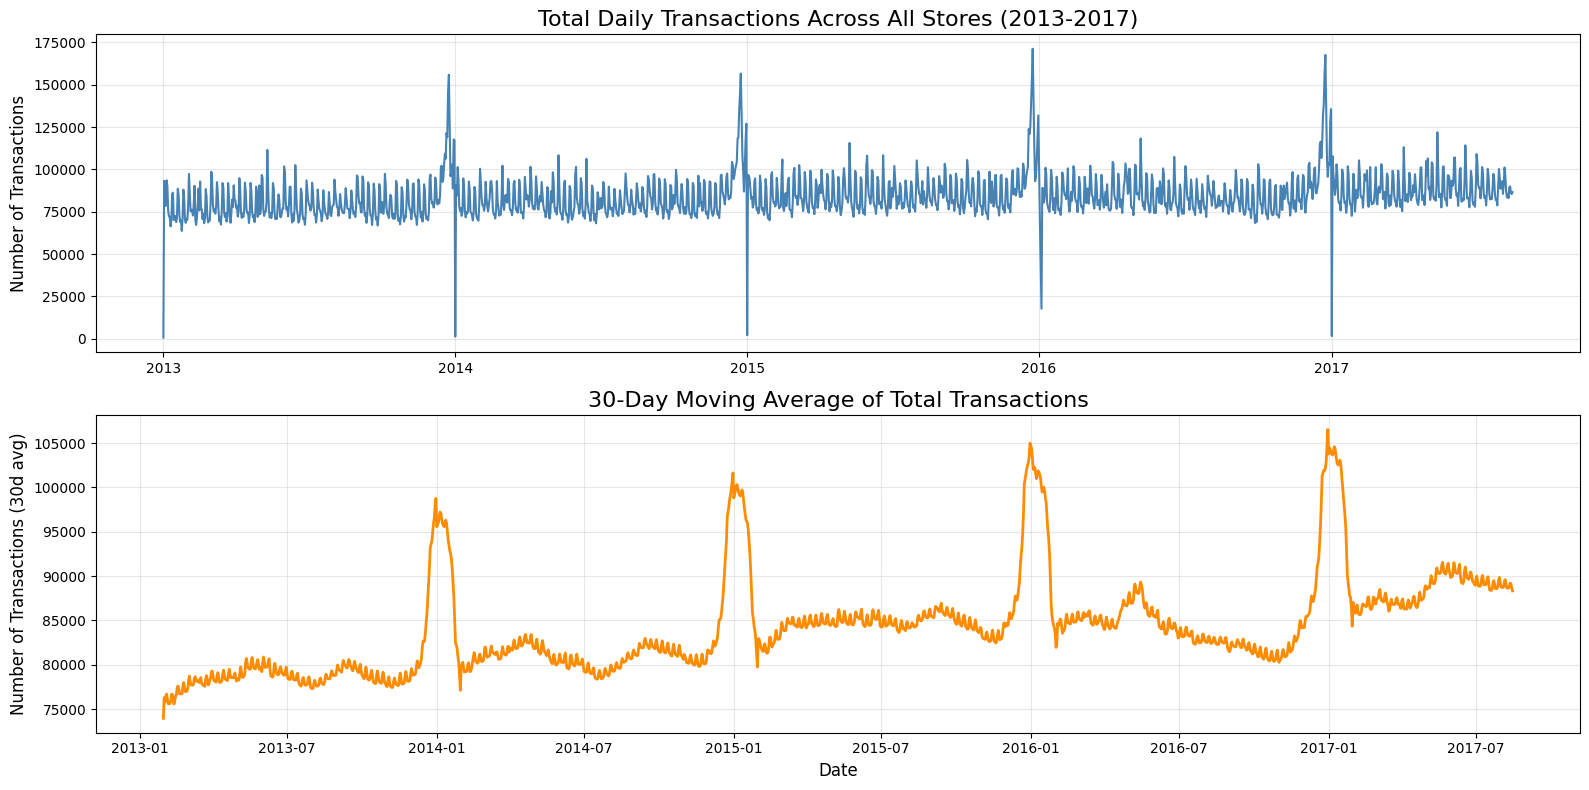

Transaction Summary Statistics:
count      1682.000000
mean      84113.522592
std       12272.597837
min         770.000000
25%       76267.250000
50%       81569.500000
75%       90773.000000
max      171169.000000
Name: transactions, dtype: float64

Top 10 Days with Highest Transaction Volumes:
           date  transactions  30d_moving_avg
1085 2015-12-24        171169   100360.466667
1448 2016-12-24        167542   101309.533333
1447 2016-12-23        156932    98274.100000
721  2014-12-24        156546    96711.100000
357  2013-12-24        155846    93244.600000
1084 2015-12-23        153338    97219.166667
356  2013-12-23        145876    90975.433333
720  2014-12-23        144513    94050.600000
1083 2015-12-22        138921    94727.433333
1446 2016-12-22        138892    95789.366667

Days with Lowest Transaction Volumes:
           date  transactions  30d_moving_avg
0    2013-01-01           770             NaN
364  2014-01-01          1327    95576.100000
1455 2017-01-01    

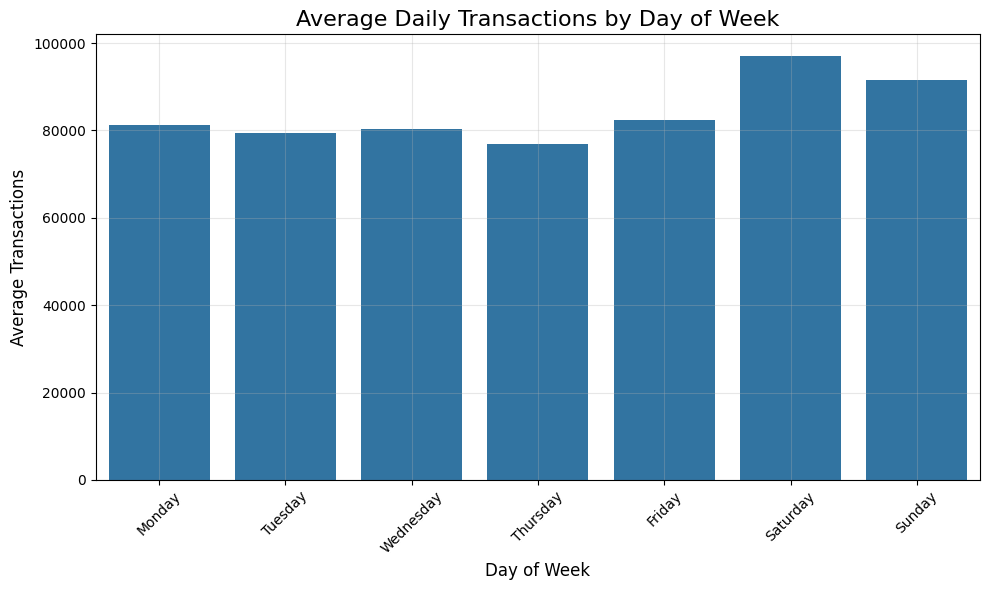

In [43]:
# Convert date to datetime if not already converted
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Group transactions by date and sum across all stores
daily_total_transactions = df_transactions.groupby('date')['transactions'].sum().reset_index()

# Create the plot
plt.figure(figsize=(16, 8))

# Main plot of total transactions over time
plt.subplot(2, 1, 1)
plt.plot(daily_total_transactions['date'], daily_total_transactions['transactions'], 
         color='steelblue', linewidth=1.5)
plt.title('Total Daily Transactions Across All Stores (2013-2017)', fontsize=16)
plt.ylabel('Number of Transactions', fontsize=12)
plt.grid(True, alpha=0.3)

# Add a 30-day moving average to see the trend more clearly
plt.subplot(2, 1, 2)
daily_total_transactions['30d_moving_avg'] = daily_total_transactions['transactions'].rolling(window=30).mean()
plt.plot(daily_total_transactions['date'], daily_total_transactions['30d_moving_avg'], 
         color='darkorange', linewidth=2)
plt.title('30-Day Moving Average of Total Transactions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions (30d avg)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print summary statistics
print("Transaction Summary Statistics:")
stats = daily_total_transactions['transactions'].describe()
print(stats)

# Identify days with highest transaction volumes
top_days = daily_total_transactions.sort_values('transactions', ascending=False).head(10)
print("\nTop 10 Days with Highest Transaction Volumes:")
print(top_days)

# Identify days with lowest transaction volumes
bottom_days = daily_total_transactions.sort_values('transactions').head(10)
print("\nDays with Lowest Transaction Volumes:")
print(bottom_days)

# Analyze transaction patterns by day of the week
daily_total_transactions['day_of_week'] = daily_total_transactions['date'].dt.dayofweek
weekday_transactions = daily_total_transactions.groupby('day_of_week')['transactions'].mean().reset_index()
weekday_transactions['day_name'] = weekday_transactions['day_of_week'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Plot transactions by day of week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_name', y='transactions', data=weekday_transactions)
plt.title('Average Daily Transactions by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Transactions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

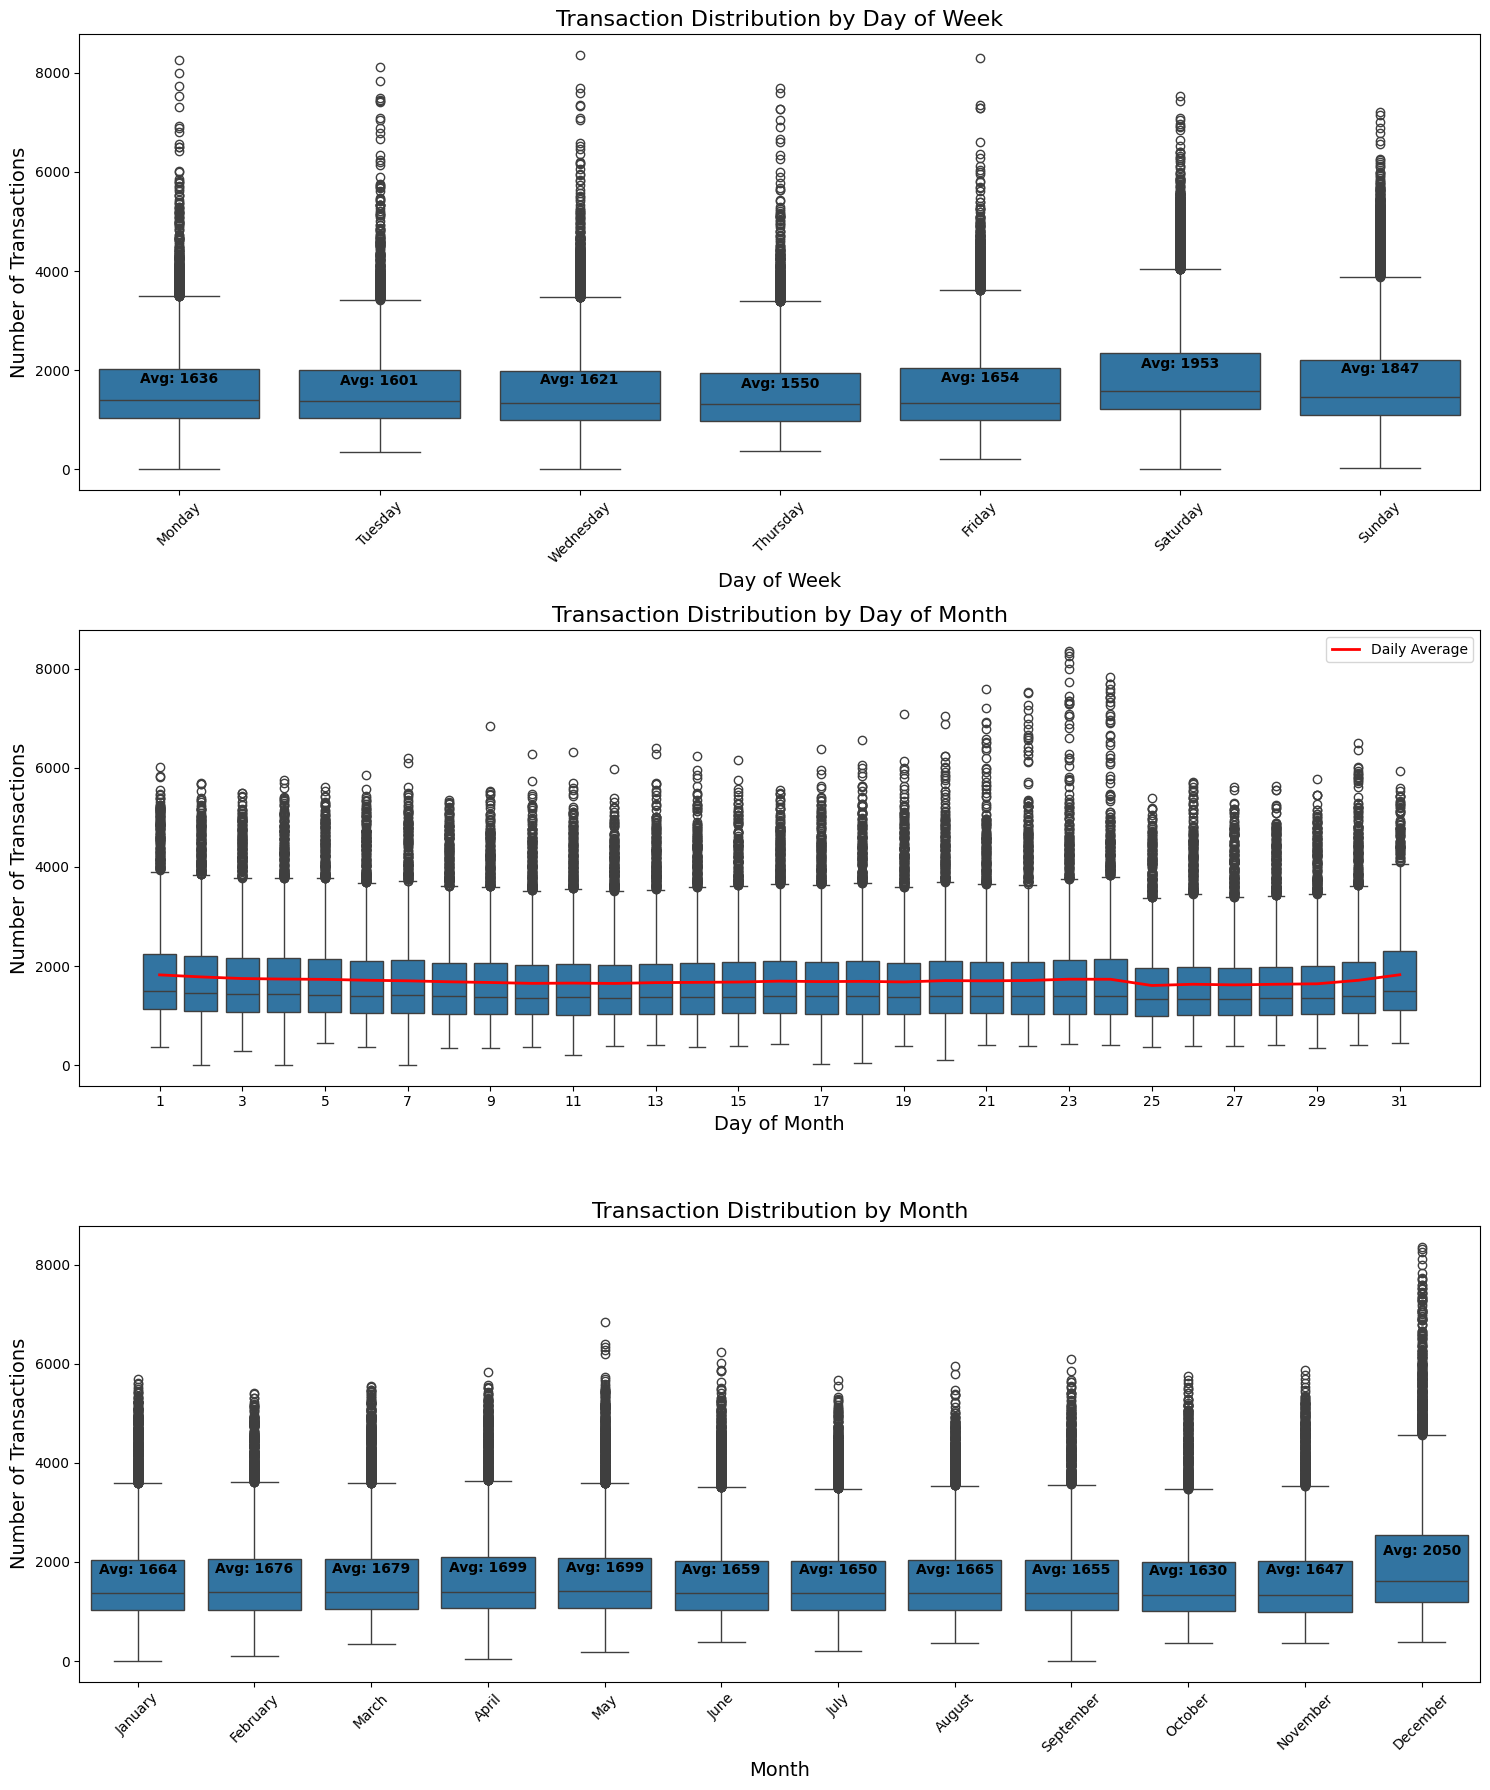

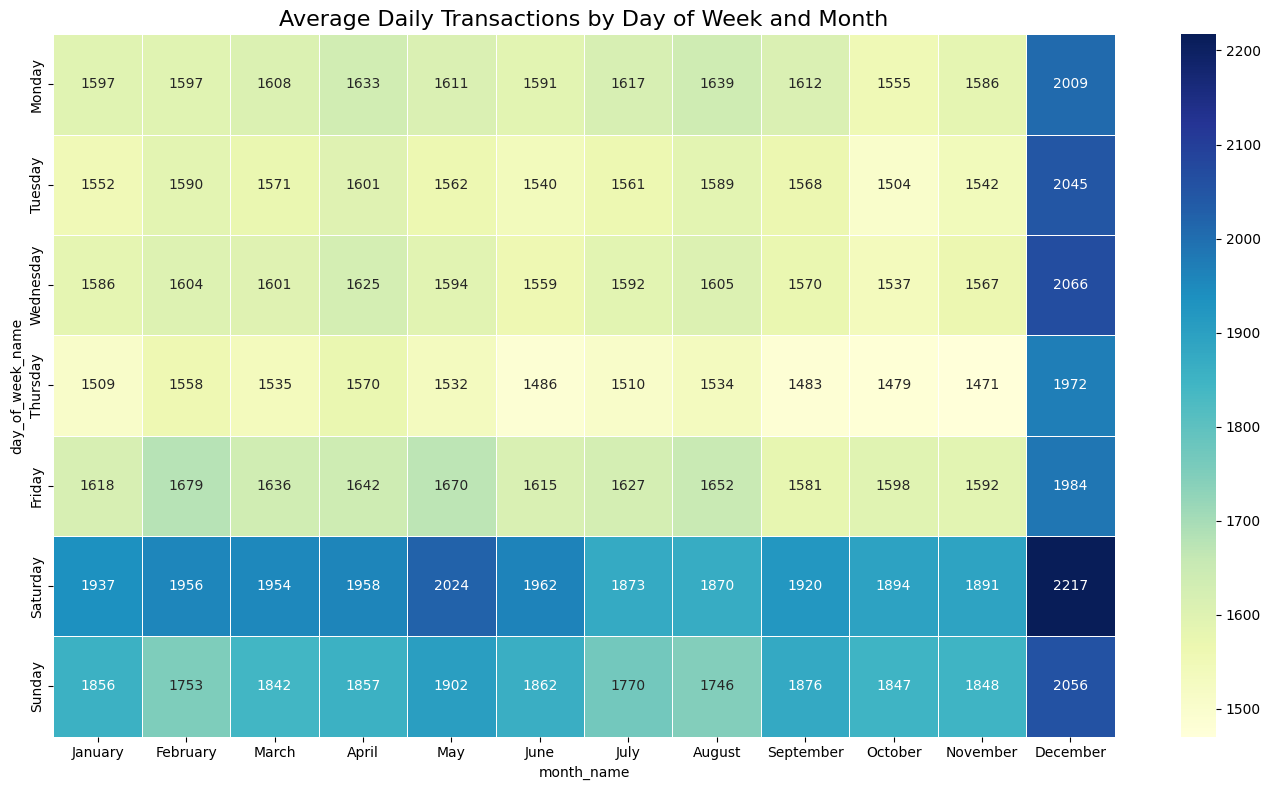

Average Transactions by Day of Week:
day_of_week_name
Saturday     1952.675786
Sunday       1847.259706
Friday       1653.989243
Monday       1635.556903
Wednesday    1621.497604
Tuesday      1601.308520
Thursday     1549.699882
Name: transactions, dtype: float64

Average Transactions by Month:
month_name
January      1664.092813
February     1676.153758
March        1678.741131
April        1699.425747
May          1699.193858
June         1658.540925
July         1650.225910
August       1664.826388
September    1655.165148
October      1629.619526
November     1647.410440
December     2050.067684
Name: transactions, dtype: float64

Top 5 Days of Month by Average Transactions:
    day_of_month  transactions
30            31   1825.323106
0              1   1822.937549
1              2   1781.612635
2              3   1748.761696
3              4   1738.235358


In [44]:
# Create time-based features from date column
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek
df_transactions['day_of_week_name'] = df_transactions['date'].dt.day_name()
df_transactions['day_of_month'] = df_transactions['date'].dt.day
df_transactions['month'] = df_transactions['date'].dt.month
df_transactions['month_name'] = df_transactions['date'].dt.month_name()
df_transactions['year'] = df_transactions['date'].dt.year
# =============================

# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# 1. Analyze transactions by day of the week
sns.boxplot(x='day_of_week_name', y='transactions', data=df_transactions, ax=axes[0], 
           order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0].set_title('Transaction Distribution by Day of Week', fontsize=16)
axes[0].set_xlabel('Day of Week', fontsize=14)
axes[0].set_ylabel('Number of Transactions', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Also add average line to see the trend more clearly
day_avgs = df_transactions.groupby('day_of_week_name')['transactions'].mean()
for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']):
    axes[0].text(i, day_avgs[day]+100, f'Avg: {day_avgs[day]:.0f}', ha='center', fontweight='bold')

# 2. Analyze transactions by day of the month
sns.boxplot(x='day_of_month', y='transactions', data=df_transactions, ax=axes[1])
axes[1].set_title('Transaction Distribution by Day of Month', fontsize=16)
axes[1].set_xlabel('Day of Month', fontsize=14)
axes[1].set_ylabel('Number of Transactions', fontsize=14)
axes[1].set_xticks(range(0, 31, 2))  # Show every other day to avoid crowding

# Add a rolling average line to see patterns
day_of_month_avgs = df_transactions.groupby('day_of_month')['transactions'].mean().reset_index()
axes[1].plot(day_of_month_avgs['day_of_month']-1, day_of_month_avgs['transactions'], 
            'r-', linewidth=2, label='Daily Average')
axes[1].legend()

# 3. Analyze transactions by month of the year
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
sns.boxplot(x='month_name', y='transactions', data=df_transactions, ax=axes[2],
           order=month_order)
axes[2].set_title('Transaction Distribution by Month', fontsize=16)
axes[2].set_xlabel('Month', fontsize=14)
axes[2].set_ylabel('Number of Transactions', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)

# Add average transactions by month
month_avgs = df_transactions.groupby('month_name')['transactions'].mean()
for i, month in enumerate(month_order):
    if month in month_avgs:
        axes[2].text(i, month_avgs[month]+100, f'Avg: {month_avgs[month]:.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: Create heatmap of transactions by day of week and month
# First aggregate data
heatmap_data = df_transactions.groupby(['day_of_week_name', 'month_name'])['transactions'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='day_of_week_name', columns='month_name', values='transactions')
heatmap_pivot = heatmap_pivot.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                    columns=month_order)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Average Daily Transactions by Day of Week and Month', fontsize=16)
plt.tight_layout()
plt.show()

# Print summary statistics by time period
print("Average Transactions by Day of Week:")
print(day_avgs.sort_values(ascending=False))

print("\nAverage Transactions by Month:")
month_avg_sorted = df_transactions.groupby('month_name')['transactions'].mean().reindex(month_order)
print(month_avg_sorted)

print("\nTop 5 Days of Month by Average Transactions:")
print(day_of_month_avgs.sort_values('transactions', ascending=False).head(5))

# Feature Engineering Transacitons

In [45]:
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek
df_transactions['day_of_week_name'] = df_transactions['date'].dt.day_name()
df_transactions['day_of_month'] = df_transactions['date'].dt.day
df_transactions['month'] = df_transactions['date'].dt.month
df_transactions['month_name'] = df_transactions['date'].dt.month_name()
df_transactions['year'] = df_transactions['date'].dt.year

# Stores + Transactions

C:\Users\gupes\AppData\Local\Temp\ipykernel_14420\1671247947.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type', y='transactions', data=type_trans, ax=axes[0, 0], palette='viridis')
C:\Users\gupes\AppData\Local\Temp\ipykernel_14420\1671247947.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='transactions', data=cluster_trans, ax=axes[0, 1], palette='magma')
C:\Users\gupes\AppData\Local\Temp\ipykernel_14420\1671247947.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='transactions', y='city', data=city_trans,

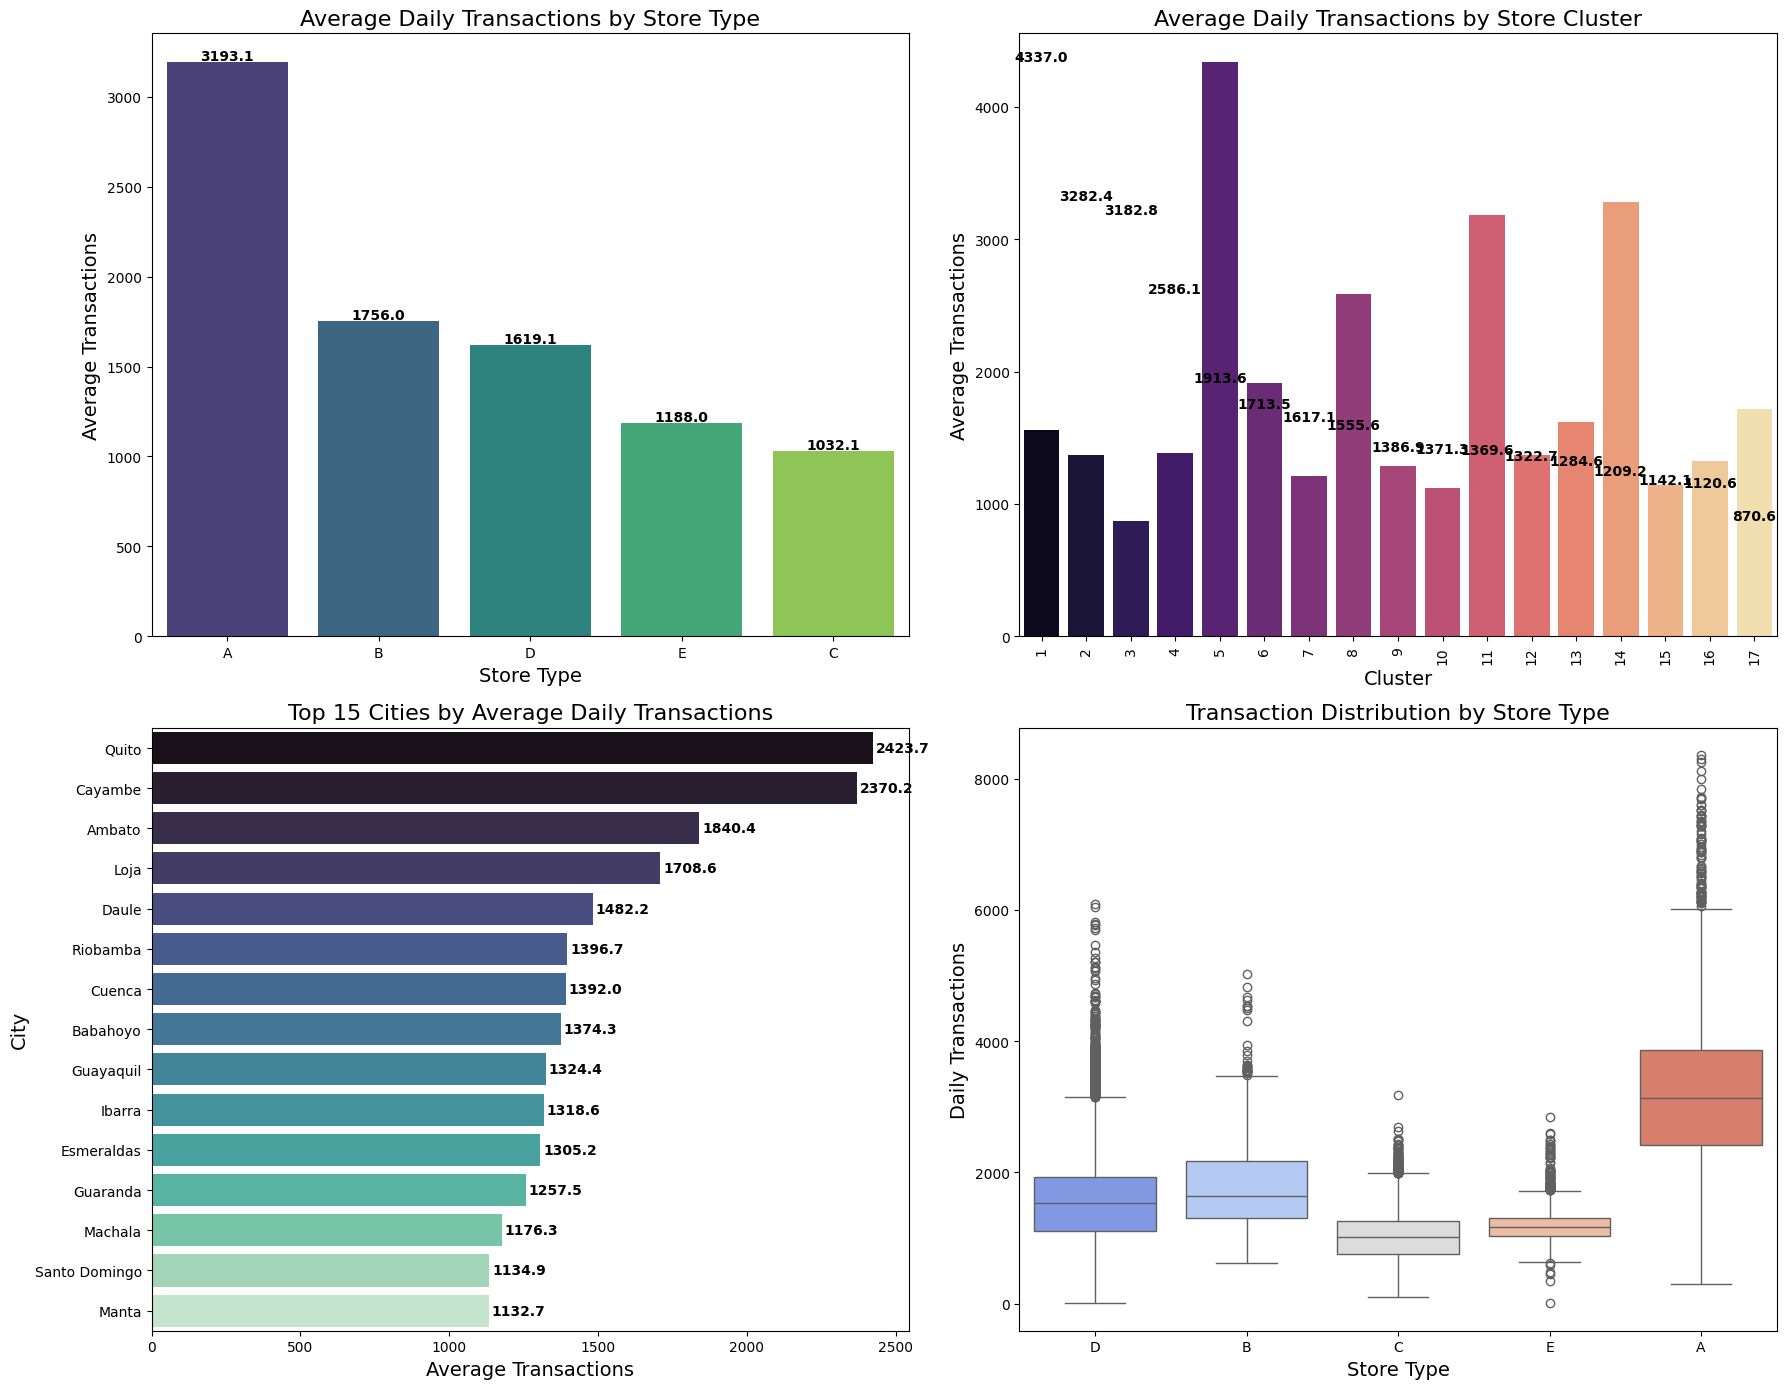

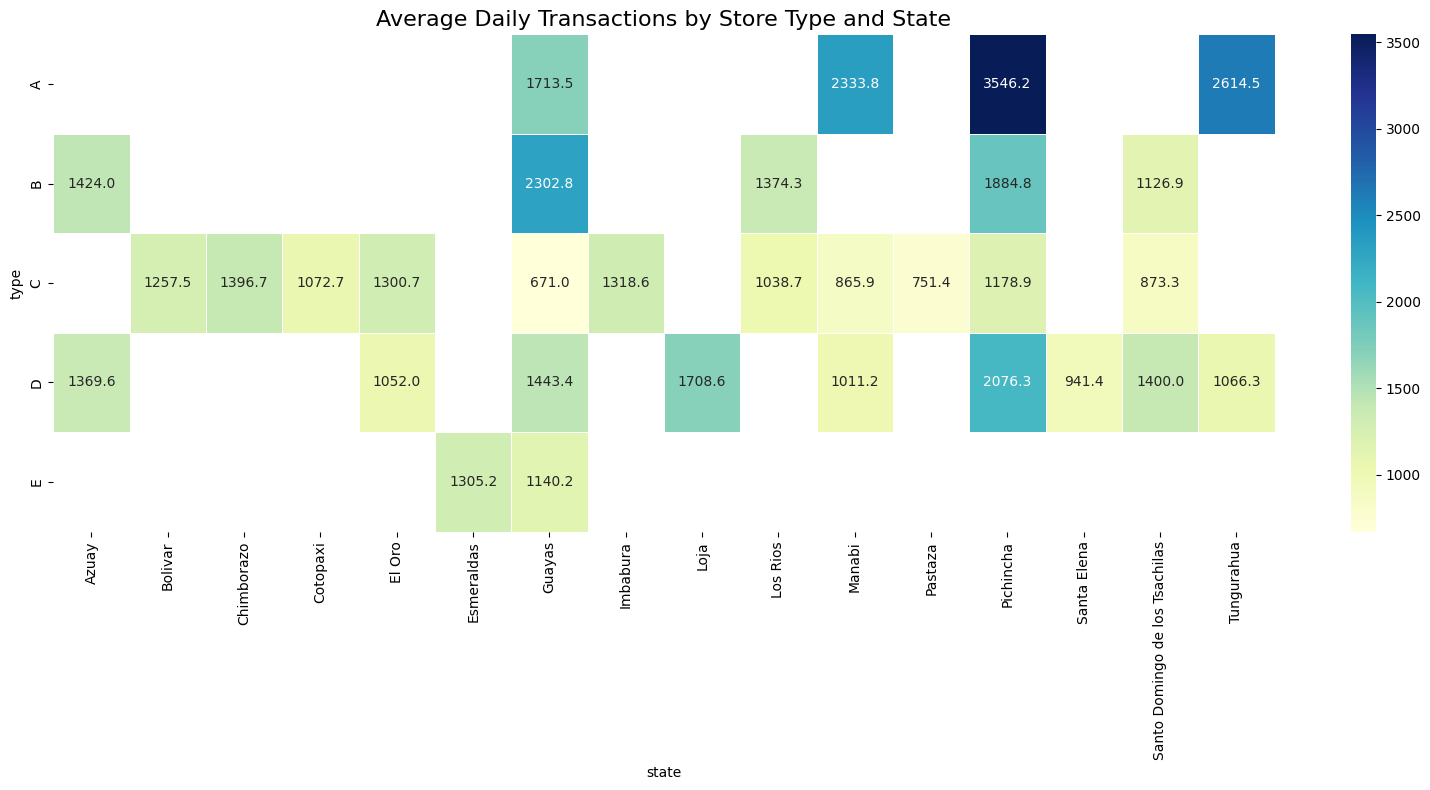


Summary of Average Transactions by Store Type:
  type  transactions
0    A   3193.104034
1    B   1755.956758
2    D   1619.097398
3    E   1188.002598
4    C   1032.099176

Summary of Average Transactions by Cluster:
   cluster  transactions
0        5   4336.966607
1       14   3282.372093
2       11   3182.779666
3        8   2586.097871
4        6   1913.637776
5       17   1713.544425
6       13   1617.146869
7        1   1555.607928
8        4   1386.938593
9       12   1371.257467

Top 10 Cities by Average Daily Transactions:
        city  transactions
0      Quito   2423.672322
1    Cayambe   2370.219570
2     Ambato   1840.374180
3       Loja   1708.612634
4      Daule   1482.222421
5   Riobamba   1396.733822
6     Cuenca   1392.013494
7   Babahoyo   1374.281287
8  Guayaquil   1324.445289
9     Ibarra   1318.554893

Correlation between cluster and average transactions: 0.219


In [46]:
# Merge the transactions data with store information
df_merged = pd.merge(df_transactions, df_stores, on='store_nbr')

# Create a figure with multiple subplots for analyzing transactions by store attributes
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Average transactions by store type
type_trans = df_merged.groupby('type')['transactions'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='type', y='transactions', data=type_trans, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Average Daily Transactions by Store Type', fontsize=16)
axes[0, 0].set_xlabel('Store Type', fontsize=14)
axes[0, 0].set_ylabel('Average Transactions', fontsize=14)

# Add values on top of bars
for i, v in enumerate(type_trans['transactions']):
    axes[0, 0].text(i, v + 10, f'{v:.1f}', ha='center', fontweight='bold')

# 2. Average transactions by cluster
cluster_trans = df_merged.groupby('cluster')['transactions'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='cluster', y='transactions', data=cluster_trans, ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Average Daily Transactions by Store Cluster', fontsize=16)
axes[0, 1].set_xlabel('Cluster', fontsize=14)
axes[0, 1].set_ylabel('Average Transactions', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=90)

# Add values on top of bars
for i, v in enumerate(cluster_trans['transactions']):
    axes[0, 1].text(i, v + 10, f'{v:.1f}', ha='center', fontweight='bold')

# 3. Top 15 cities by average transactions
city_trans = df_merged.groupby('city')['transactions'].mean().sort_values(ascending=False).head(15).reset_index()
sns.barplot(x='transactions', y='city', data=city_trans, ax=axes[1, 0], palette='mako')
axes[1, 0].set_title('Top 15 Cities by Average Daily Transactions', fontsize=16)
axes[1, 0].set_xlabel('Average Transactions', fontsize=14)
axes[1, 0].set_ylabel('City', fontsize=14)

# Add values on end of bars
for i, v in enumerate(city_trans['transactions']):
    axes[1, 0].text(v + 10, i, f'{v:.1f}', va='center', fontweight='bold')

# 4. Boxplot of transactions by store type
sns.boxplot(x='type', y='transactions', data=df_merged, ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Transaction Distribution by Store Type', fontsize=16)
axes[1, 1].set_xlabel('Store Type', fontsize=14)
axes[1, 1].set_ylabel('Daily Transactions', fontsize=14)

plt.tight_layout()
plt.show()

# Additional analysis - Heatmap of average transactions by store type and state
type_state_trans = df_merged.groupby(['type', 'state'])['transactions'].mean().reset_index()
type_state_pivot = type_state_trans.pivot_table(index='type', columns='state', values='transactions')

plt.figure(figsize=(16, 8))
sns.heatmap(type_state_pivot, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)
plt.title('Average Daily Transactions by Store Type and State', fontsize=16)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Average Transactions by Store Type:")
print(type_trans)

print("\nSummary of Average Transactions by Cluster:")
print(cluster_trans.head(10))

print("\nTop 10 Cities by Average Daily Transactions:")
print(city_trans.head(10))

# Calculate correlations between store attributes and transactions
store_trans_avg = df_merged.groupby('store_nbr')['transactions'].mean().reset_index()
store_attributes = pd.merge(store_trans_avg, df_stores, on='store_nbr')

# Convert categorical variables to dummy variables for correlation analysis
store_attributes_encoded = pd.get_dummies(store_attributes, columns=['type', 'city', 'state'])
correlation = store_attributes_encoded['transactions'].corr(store_attributes_encoded['cluster'])

print(f"\nCorrelation between cluster and average transactions: {correlation:.3f}")

C:\Users\gupes\AppData\Local\Temp\ipykernel_14420\4165586319.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(day_order)
C:\Users\gupes\AppData\Local\Temp\ipykernel_14420\4165586319.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(day_order)


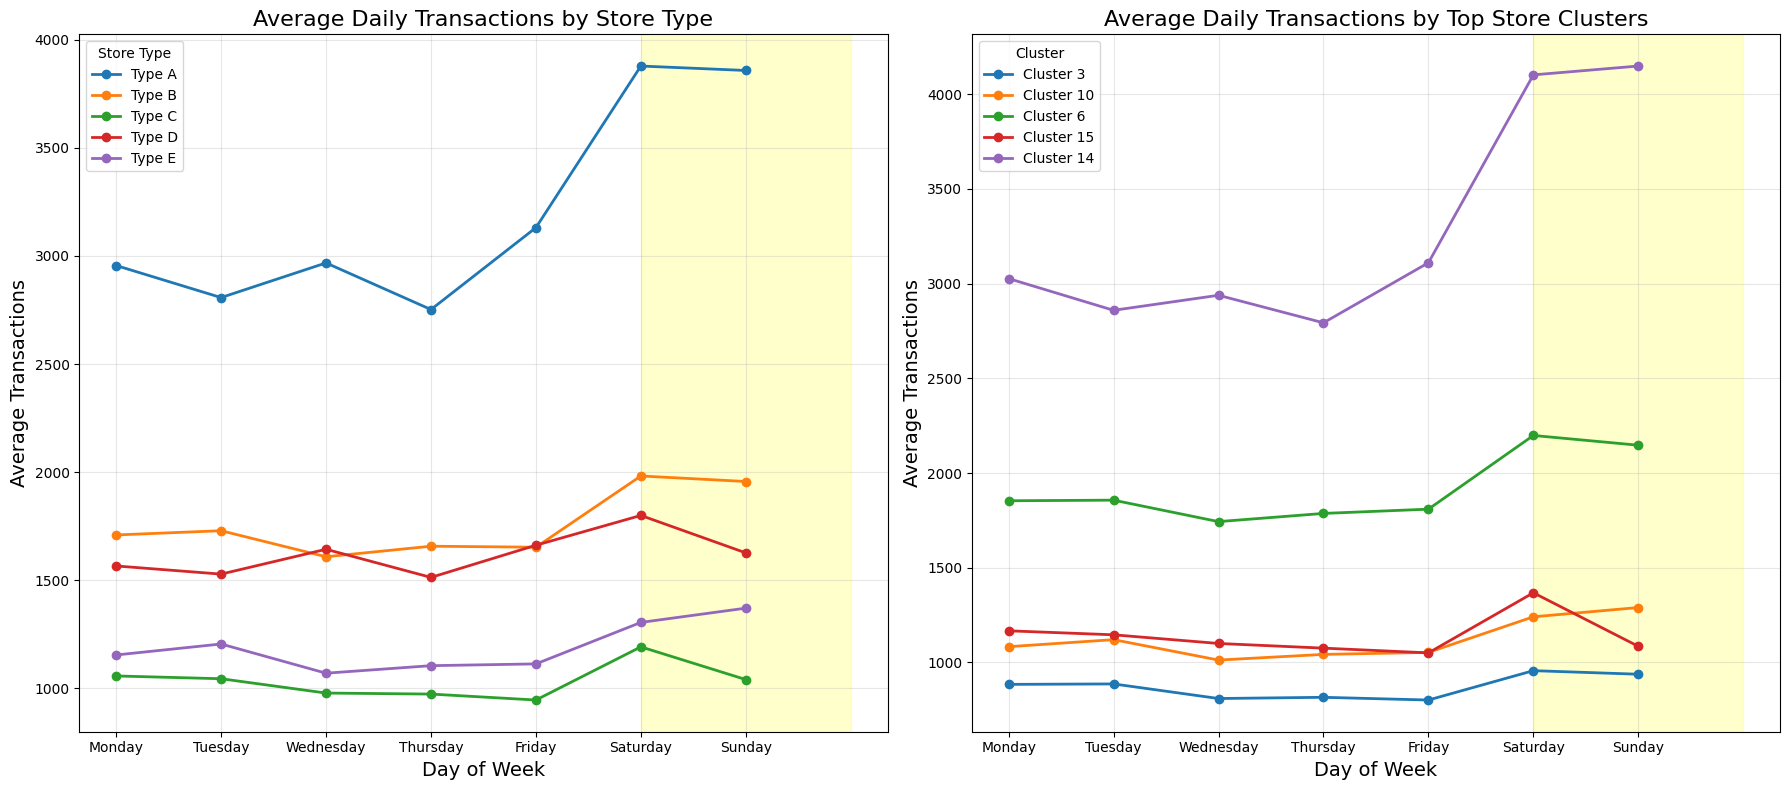

Weekend vs. Weekday Transactions by Store Type:
          weekday      weekend  pct_change
type                                      
A     2922.806889  3869.056648   32.374693
E     1128.520854  1336.670909   18.444502
B     1670.865477  1969.031693   17.845016
C      998.776981  1115.477544   11.684346
D     1581.617997  1712.924663    8.302047


In [47]:
# Convert date to datetime if not already
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Add day of week information
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek
df_transactions['day_name'] = df_transactions['date'].dt.day_name()

# Merge with store information to get store types and clusters
trans_stores = pd.merge(df_transactions, df_stores, on='store_nbr')

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 1. Compare transactions by day of week for each store type
day_type_trans = trans_stores.groupby(['day_of_week', 'day_name', 'type'])['transactions'].mean().reset_index()
day_type_pivot = day_type_trans.pivot(index=['day_of_week', 'day_name'], columns='type', values='transactions')

# Sort days correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_type_pivot = day_type_pivot.reset_index().sort_values('day_of_week')

# Plot store types
for store_type in sorted(trans_stores['type'].unique()):
    ax1.plot(day_type_pivot['day_name'], day_type_pivot[store_type], 
             marker='o', linewidth=2, label=f'Type {store_type}')

ax1.set_title('Average Daily Transactions by Store Type', fontsize=16)
ax1.set_xlabel('Day of Week', fontsize=14)
ax1.set_ylabel('Average Transactions', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Store Type')
ax1.set_xticklabels(day_order)

# 2. Compare transactions by day of week for top store clusters
# Get top 5 clusters by count
top_clusters = trans_stores['cluster'].value_counts().nlargest(5).index.tolist()

# Filter for those clusters
trans_top_clusters = trans_stores[trans_stores['cluster'].isin(top_clusters)]

# Group by day and cluster
day_cluster_trans = trans_top_clusters.groupby(['day_of_week', 'day_name', 'cluster'])['transactions'].mean().reset_index()
day_cluster_pivot = day_cluster_trans.pivot(index=['day_of_week', 'day_name'], columns='cluster', values='transactions')

# Sort days correctly
day_cluster_pivot = day_cluster_pivot.reset_index().sort_values('day_of_week')

# Plot clusters 
for cluster in top_clusters:
    ax2.plot(day_cluster_pivot['day_name'], day_cluster_pivot[cluster], 
             marker='o', linewidth=2, label=f'Cluster {cluster}')

ax2.set_title('Average Daily Transactions by Top Store Clusters', fontsize=16)
ax2.set_xlabel('Day of Week', fontsize=14)
ax2.set_ylabel('Average Transactions', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Cluster')
ax2.set_xticklabels(day_order)

# Highlight weekends
for ax in [ax1, ax2]:
    ax.axvspan(5, 7, alpha=0.2, color='yellow', label='Weekend')

plt.tight_layout()
plt.show()

# Calculate percentage change from weekday to weekend for each store type
weekend_analysis = trans_stores.copy()
weekend_analysis['is_weekend'] = weekend_analysis['day_of_week'].isin([5, 6])  # Saturday and Sunday

# Calculate average transactions by store type and weekend status
weekend_type_trans = weekend_analysis.groupby(['type', 'is_weekend'])['transactions'].mean().reset_index()
weekend_type_pivot = weekend_type_trans.pivot(index='type', columns='is_weekend', values='transactions')
weekend_type_pivot.columns = ['weekday', 'weekend']
weekend_type_pivot['pct_change'] = (weekend_type_pivot['weekend'] - weekend_type_pivot['weekday']) / weekend_type_pivot['weekday'] * 100

print("Weekend vs. Weekday Transactions by Store Type:")
print(weekend_type_pivot.sort_values('pct_change', ascending=False))

## Feature Engineering

In [48]:
df_base = pd.merge(df_transactions, df_stores, on='store_nbr', how='left')

mean_per_store = df_base.groupby('store_nbr')['transactions'].mean().reset_index()
mean_per_store = mean_per_store.rename(columns={'transactions': 'mean_transactions_per_store'})
df_train = pd.merge(df_train, mean_per_store, on='store_nbr', how='left')
display(df_train.head())


,id,date,store_nbr,family,sales,onpromotion,type,locale,description,transferred,...,is_transferred,holiday-4,holiday-3,holiday-2,holiday-1,holiday+1,holiday+2,holiday+3,holiday+4,mean_transactions_per_store
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,0,0,0,0,0,1523.844272
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,0,0,0,0,0,1523.844272
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,0,0,0,0,0,1523.844272
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,0,0,0,0,0,1523.844272
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,0,0,0,0,0,1523.844272


In [49]:
mean_per_cluster = df_base.groupby('cluster')['transactions'].mean().reset_index()
mean_per_cluster = mean_per_cluster.rename(columns={'transactions': 'mean_transactions_per_cluster'})
df_train = pd.merge(df_train, df_stores, on='store_nbr', how='left')
df_train = pd.merge(df_train, mean_per_cluster, on='cluster', how='left')

display(df_train.head())

,id,date,store_nbr,family,sales,onpromotion,type_x,locale,description,transferred,...,holiday+1,holiday+2,holiday+3,holiday+4,mean_transactions_per_store,city,state,type_y,cluster,mean_transactions_per_cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,1523.844272,Quito,Pichincha,D,13,1617.146869
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,1523.844272,Quito,Pichincha,D,13,1617.146869
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,1523.844272,Quito,Pichincha,D,13,1617.146869
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,1523.844272,Quito,Pichincha,D,13,1617.146869
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Primer dia del ano,False,...,0,0,0,0,1523.844272,Quito,Pichincha,D,13,1617.146869


In [50]:
df_train['date'] = pd.to_datetime(df_train['date'])

df_train['day_of_week'] = df_train['date'].dt.dayofweek # Segunda=0, ..., Domingo=6
df_train['month'] = df_train['date'].dt.month               # Mês como um número (1-12)

print(df_train[['date', 'day_of_week', 'month']].head())


        date  day_of_week  month
0 2013-01-01            1      1
1 2013-01-01            1      1
2 2013-01-01            1      1
3 2013-01-01            1      1
4 2013-01-01            1      1


# Oil

In [ ]:
df_oil['date'] = pd.to_datetime(df_oil['date'])
full_date_range = pd.date_range(start=df_train['date'].min(), end=df_test['date'].max(), freq='D')
df_oil_full = pd.DataFrame(index=full_date_range)

# Juntar os preços do petróleo
df_oil_full = df_oil_full.join(df_oil.set_index('date'))

# Preencher valores ausentes: bfill() preenche os primeiros dias que podem estar faltando, ffill() preenche os fins de semana e feriados com o último valor válido
df_oil_full = df_oil_full.bfill().ffill()

df_oil_full = df_oil_full.rename(columns={'dcoilwtico': 'preco_petroleo'}).reset_index().rename(columns={'index': 'date'})

print("df_oil preparado com sucesso:")
print(df_oil_full.head())

# Training and Predicting

## Reloading variables

In [76]:
script_dir = Path('__file__').resolve().parent
data_path = script_dir.joinpath('data')

df_holidays = pd.read_csv(data_path.joinpath('holidays_events.csv'))
df_oil = pd.read_csv(data_path.joinpath('oil.csv'))
df_stores = pd.read_csv(data_path.joinpath('stores.csv'))
df_transactions = pd.read_csv(data_path.joinpath('transactions.csv'))
df_test = pd.read_csv(data_path.joinpath('test.csv'))
df_train = pd.read_csv(data_path.joinpath('train.csv'))

In [77]:
run = 'RFR'

# LightGBM

In [78]:
if run == 'LGBM':    
    def feature_engineering_train(df, stores_df, transactions_df, holidays_df):
        """
        Executa a engenharia de features completa para o conjunto de treino.
        Calcula e retorna os agregados aprendidos.
        """
        print("Iniciando engenharia de features para o conjunto de TREINO...")

        # --- 1. Merges Iniciais ---
        # PRIMEIRO, fazemos o merge com stores_df para obter a coluna 'cluster'
        df = pd.merge(df, stores_df, on='store_nbr', how='left')
        df = pd.merge(df, transactions_df, on=['date', 'store_nbr'], how='left')

        # --- 2. Features de Data ---
        df['date'] = pd.to_datetime(df['date'])
        df['dia_da_semana'] = df['date'].dt.dayofweek
        df['mes'] = df['date'].dt.month
        df['ano'] = df['date'].dt.year
        df['dia_do_ano'] = df['date'].dt.dayofyear
        df['semana_do_ano'] = df['date'].dt.isocalendar().week.astype(int)

        # --- 3. Features de Feriados ---
        holidays_df['date'] = pd.to_datetime(holidays_df['date'])
        holidays_simple = holidays_df[holidays_df['locale'] == 'National'][['date', 'description']].rename(columns={'description': 'feriado_nacional'})
        df = pd.merge(df, holidays_simple, on='date', how='left')
        df['e_feriado'] = df['feriado_nacional'].notna().astype(int)


        display(df.columns.to_list())
        # --- 4. CALCULAR Agregados (A parte "Fit") ---
        print("Calculando agregados a partir dos dados de treino...")
        agg_loja_mean = df.groupby('store_nbr')['transactions'].mean().reset_index().rename(columns={'transactions': 'media_transacoes_loja'})
        agg_loja_std = df.groupby('store_nbr')['transactions'].std().reset_index().rename(columns={'transactions': 'std_transacoes_loja'})
        # Agora o groupby('cluster') vai funcionar, pois a coluna foi adicionada no Passo 1
        agg_cluster_mean = df.groupby('cluster')['transactions'].mean().reset_index().rename(columns={'transactions': 'media_transacoes_cluster'})

        learned_aggregates = {
            'agg_loja_mean': agg_loja_mean,
            'agg_loja_std': agg_loja_std,
            'agg_cluster_mean': agg_cluster_mean
        }

        # --- 5. Juntar os agregados calculados ao dataframe ---
        df = pd.merge(df, agg_loja_mean, on='store_nbr', how='left')
        df = pd.merge(df, agg_loja_std, on='store_nbr', how='left')
        df = pd.merge(df, agg_cluster_mean, on='cluster', how='left')

        df = df.drop(columns=['feriado_nacional'])
        df = df.fillna(0)

        print("Engenharia de features do TREINO concluída.")
        # A função retorna DOIS valores
        return df, learned_aggregates


    def feature_engineering_test(df, stores_df, holidays_df, learned_aggregates):
        """
        Aplica a engenharia de features no conjunto de teste USANDO os agregados pré-calculados.
        """
        print("Iniciando engenharia de features para o conjunto de TESTE...")

        # --- 1. Merges Iniciais ---
        # A mesma lógica do treino: primeiro o merge com stores_df
        df = pd.merge(df, stores_df, on='store_nbr', how='left')

        # --- 2. Features de Data ---
        df['date'] = pd.to_datetime(df['date'])
        df['dia_da_semana'] = df['date'].dt.dayofweek
        df['mes'] = df['date'].dt.month
        df['ano'] = df['date'].dt.year
        df['dia_do_ano'] = df['date'].dt.dayofyear
        df['semana_do_ano'] = df['date'].dt.isocalendar().week.astype(int)

        # --- 3. Features de Feriados ---
        holidays_df['date'] = pd.to_datetime(holidays_df['date'])
        holidays_simple = holidays_df[holidays_df['locale'] == 'National'][['date', 'description']].rename(columns={'description': 'feriado_nacional'})
        df = pd.merge(df, holidays_simple, on='date', how='left')
        df['e_feriado'] = df['feriado_nacional'].notna().astype(int)

        # --- 4. APLICAR Agregados ---
        print("Aplicando agregados aprendidos no conjunto de teste...")
        df = pd.merge(df, learned_aggregates['agg_loja_mean'], on='store_nbr', how='left')
        df = pd.merge(df, learned_aggregates['agg_loja_std'], on='store_nbr', how='left')
        # O merge com 'cluster' agora funciona, pois a coluna foi adicionada no passo 1
        df = pd.merge(df, learned_aggregates['agg_cluster_mean'], on='cluster', how='left')

        df = df.drop(columns=['feriado_nacional'])
        df = df.fillna(0)
        
        print("Engenharia de features do TESTE concluída.")
        return df

    # CORREÇÃO NA CHAMADA DAS FUNÇÕES
    # A primeira função retorna DUAS variáveis, que precisam ser capturadas
    df_train_final, learned_aggregates = feature_engineering_train(
        df_train.copy(),
        df_stores,
        df_transactions,
        df_holidays
    )

    # A segunda função usa o dicionário 'learned_aggregates' que acabamos de criar
    df_test_final = feature_engineering_test(
        df_test.copy(),
        df_stores,
        df_holidays,
        learned_aggregates # Passando o dicionário correto
    )

    print("\nCélula executada com sucesso!")
    # As colunas devem ser as mesmas, exceto por 'sales'
    df_test_final['sales'] = np.nan # Adiciona uma coluna 'sales' vazia no teste para a união

    # Concatena os dois dataframes
    df_full = pd.concat([df_train_final, df_test_final], ignore_index=True)

    # Ordenar é crucial para que a janela deslizante funcione corretamente
    df_full = df_full.sort_values(by=['store_nbr', 'family', 'date'])

    def create_sliding_window_features(df):
        print("Criando features de janela deslizante...")
        
        # Definindo os lags e janelas que queremos criar
        lags = [7, 14, 28] # Vendas da semana passada, 2 semanas atrás, 4 semanas atrás
        windows = [7, 14, 28] # Médias móveis da última semana, últimas 2 e 4 semanas
        
        # Agrupando por cada série temporal individual (loja + família de produto)
        grouped = df.groupby(['store_nbr', 'family'])
        
        # Criando Lag Features
        for lag in lags:
            df[f'sales_lag_{lag}'] = grouped['sales'].shift(lag)
            
        # Criando Rolling Window Features
        for window in windows:
            df[f'sales_rolling_mean_{window}'] = grouped['sales'].shift(1).rolling(window).mean()
            df[f'sales_rolling_std_{window}'] = grouped['sales'].shift(1).rolling(window).std()
            
        # Preencher NaNs que surgem no início das séries
        df = df.fillna(-1) # Usamos -1 ou outra flag para indicar que não havia dados
        
        print("Features de janela criadas.")
        return df

    # Aplicando a função no dataframe completo
    df_full_featured = create_sliding_window_features(df_full)

    print("Convertendo colunas categóricas para o tipo 'category'...")
    colunas_categoricas = ['family', 'city', 'state', 'type']
    for col in colunas_categoricas:
        df_full_featured[col] = df_full_featured[col].astype('category')

    # Separar de volta em treino e teste
    df_train_processed = df_full_featured[df_full_featured['sales'] != -1]
    df_test_processed = df_full_featured[df_full_featured['sales'] == -1]


    # Criando um conjunto de validação com as últimas 4 semanas de dados de treino
    validation_period_days = 28
    train_max_date = pd.to_datetime(df_train_processed['date'].max())
    validation_start_date = train_max_date - pd.to_timedelta(validation_period_days, unit='D')

    df_validation = df_train_processed[pd.to_datetime(df_train_processed['date']) > validation_start_date]
    df_train_split = df_train_processed[pd.to_datetime(df_train_processed['date']) <= validation_start_date]

    print(f"Tamanho do Treino: {df_train_split.shape}")
    print(f"Tamanho da Validação: {df_validation.shape}")

    # Definir colunas de features (todas exceto o alvo e identificadores)
    features = [col for col in df_train_split.columns if col not in ['id', 'date', 'sales']]
    target = 'sales'

    # Preparar os dados para o LightGBM
    X_train = df_train_split[features]
    y_train = df_train_split[target]
    X_val = df_validation[features]
    y_val = df_validation[target]
    X_test = df_test_processed[features]

    # Parâmetros do LightGBM (um bom ponto de partida)
    params = {
        'objective': 'regression_l1', # MAE (Mean Absolute Error)
        'metric': 'rmse', # Root Mean Squared Error
        'n_estimators': 2000,
        'learning_rate': 0.02,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
        'boosting_type': 'gbdt',
    }

    # Treinar o modelo com early stopping
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(100, verbose=True)])

    # Previsão no conjunto de teste
    predictions = model.predict(X_test)

    # Importante: Vendas não podem ser negativas!
    predictions[predictions < 0] = 0
# Criar o dataframe de submissão
submission = pd.DataFrame({
    'id': df_test_processed['id'],
    'sales': predictions
})

# Salvar o arquivo
submission.to_csv('lightgbm_submission.csv', index=False)

print("Arquivo de submissão 'submission.csv' criado com sucesso!")

Arquivo de submissão 'submission.csv' criado com sucesso!


# Random Forest Regressor

In [79]:
if run == 'RFR':
    def feature_engineering_train_simplified(df, stores_df, transactions_df, holidays_df):
        """
        Versão SIMPLIFICADA da engenharia de features para o treino.
        NÃO cria features de janela deslizante (lags/rolling).
        """
        print("Iniciando engenharia de features SIMPLIFICADA para o conjunto de TREINO...")

        # --- 1. Merges Iniciais ---
        df = pd.merge(df, stores_df, on='store_nbr', how='left')
        df = pd.merge(df, transactions_df, on=['date', 'store_nbr'], how='left')

        # --- 2. Features de Data ---
        df['date'] = pd.to_datetime(df['date'])
        df['dia_da_semana'] = df['date'].dt.dayofweek
        df['mes'] = df['date'].dt.month
        df['ano'] = df['date'].dt.year
        df['dia_do_ano'] = df['date'].dt.dayofyear
        
        # --- 3. Features de Feriados ---
        holidays_df['date'] = pd.to_datetime(holidays_df['date'])
        holidays_simple = holidays_df[holidays_df['locale'] == 'National'][['date', 'description']].rename(columns={'description': 'feriado_nacional'})
        df = pd.merge(df, holidays_simple, on='date', how='left')
        df['e_feriado'] = df['feriado_nacional'].notna().astype(int)

        # --- 4. CALCULAR Agregados a partir das Transações ---
        print("Calculando agregados a partir dos dados de treino...")
        agg_loja_mean = df.groupby('store_nbr')['transactions'].mean().reset_index().rename(columns={'transactions': 'media_transacoes_loja'})
        agg_cluster_mean = df.groupby('cluster')['transactions'].mean().reset_index().rename(columns={'transactions': 'media_transacoes_cluster'})

        learned_aggregates = {
            'agg_loja_mean': agg_loja_mean,
            'agg_cluster_mean': agg_cluster_mean
        }

        # --- 5. Juntar os agregados calculados ---
        df = pd.merge(df, agg_loja_mean, on='store_nbr', how='left')
        df = pd.merge(df, agg_cluster_mean, on='cluster', how='left')

        # --- 6. Converter Colunas Categóricas em Números ---
        # RandomForest não lida com o tipo 'category' como o LightGBM.
        # Usaremos pd.factorize para converter texto em códigos numéricos.
        categorical_cols = ['family', 'city', 'state', 'type']
        for col in categorical_cols:
            df[col], _ = pd.factorize(df[col])
            
        # --- Limpeza Final ---
        df = df.drop(columns=['feriado_nacional', 'transactions']) # Remove colunas auxiliares/vazadas
        df = df.fillna(0)
        
        print("Engenharia de features do TREINO concluída.")
        return df, learned_aggregates


    def feature_engineering_test_simplified(df, stores_df, holidays_df, learned_aggregates):
        """
        Aplica a engenharia de features SIMPLIFICADA no conjunto de teste.
        """
        print("Iniciando engenharia de features SIMPLIFICADA para o conjunto de TESTE...")

        # --- 1. Merges Iniciais ---
        df = pd.merge(df, stores_df, on='store_nbr', how='left')

        # --- 2. Features de Data ---
        df['date'] = pd.to_datetime(df['date'])
        df['dia_da_semana'] = df['date'].dt.dayofweek
        df['mes'] = df['date'].dt.month
        df['ano'] = df['date'].dt.year
        df['dia_do_ano'] = df['date'].dt.dayofyear

        # --- 3. Features de Feriados ---
        holidays_df['date'] = pd.to_datetime(holidays_df['date'])
        holidays_simple = holidays_df[holidays_df['locale'] == 'National'][['date', 'description']].rename(columns={'description': 'feriado_nacional'})
        df = pd.merge(df, holidays_simple, on='date', how='left')
        df['e_feriado'] = df['feriado_nacional'].notna().astype(int)

        # --- 4. APLICAR Agregados Aprendidos ---
        print("Aplicando agregados aprendidos...")
        df = pd.merge(df, learned_aggregates['agg_loja_mean'], on='store_nbr', how='left')
        df = pd.merge(df, learned_aggregates['agg_cluster_mean'], on='cluster', how='left')

        # --- 5. Converter Colunas Categóricas em Números ---
        categorical_cols = ['family', 'city', 'state', 'type']
        for col in categorical_cols:
            df[col], _ = pd.factorize(df[col])

        # --- Limpeza Final ---
        df = df.drop(columns=['feriado_nacional'])
        df = df.fillna(0)
        
        print("Engenharia de features do TESTE concluída.")
        return df
    
    # 1. Executar a nova engenharia de features
    df_train_processed, learned_aggregates = feature_engineering_train_simplified(
        df_train.copy(), df_stores, df_transactions, df_holidays
    )
    df_test_processed = feature_engineering_test_simplified(
        df_test.copy(), df_stores, df_holidays, learned_aggregates
    )

    # 2. Divisão por Tempo para Validação (continua sendo uma boa prática)
    print("\nSeparando dados em treino e validação...")
    validation_period_days = 28
    train_max_date = pd.to_datetime(df_train_processed['date'].max())
    validation_start_date = train_max_date - pd.to_timedelta(validation_period_days, unit='D')

    df_validation = df_train_processed[pd.to_datetime(df_train_processed['date']) > validation_start_date]
    df_train_split = df_train_processed[pd.to_datetime(df_train_processed['date']) <= validation_start_date]

    print(f"Tamanho do Treino: {df_train_split.shape}")
    print(f"Tamanho da Validação: {df_validation.shape}")

    # 3. Preparar dados para o Modelo
    features = [col for col in df_train_split.columns if col not in ['id', 'date', 'sales']]
    target = 'sales'

    X_train = df_train_split[features]
    y_train = df_train_split[target]
    X_val = df_validation[features]
    y_val = df_validation[target]
    X_test = df_test_processed[features]

    # 4. Treinar o RandomForestRegressor
    print("\nIniciando o treinamento do RandomForestRegressor...")
    # Usamos menos estimadores para um treino mais rápido como baseline
    model = RandomForestRegressor(
        n_estimators=50, # Número de árvores. Comece com um valor menor.
        max_depth=15,    # Profundidade máxima para evitar overfitting.
        min_samples_leaf=10, # Mínimo de amostras em uma folha.
        n_jobs=-1,       # Usar todos os processadores disponíveis
        random_state=42
    )

    model.fit(X_train, y_train)

    # 5. Avaliar o modelo no conjunto de validação
    val_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"\nRMSE na Validação: {rmse:.4f}")

    # 6. Previsão final e criação do arquivo de submissão
    print("\nFazendo previsões no conjunto de teste...")
    predictions = model.predict(X_test)
    predictions[predictions < 0] = 0 # Garantir que não há vendas negativas

    submission = pd.DataFrame({'id': df_test_processed['id'], 'sales': predictions})
    submission.to_csv('submission_random_forest_without_oil.csv', index=False)

    print("\nArquivo 'submission_random_forest_without_oil.csv' criado com sucesso!")

Iniciando engenharia de features SIMPLIFICADA para o conjunto de TREINO...
Calculando agregados a partir dos dados de treino...
Engenharia de features do TREINO concluída.
Iniciando engenharia de features SIMPLIFICADA para o conjunto de TESTE...
Aplicando agregados aprendidos...
Engenharia de features do TESTE concluída.

Separando dados em treino e validação...
Tamanho do Treino: (2958120, 17)
Tamanho da Validação: (49896, 17)

Iniciando o treinamento do RandomForestRegressor...

RMSE na Validação: 281.9879

Fazendo previsões no conjunto de teste...

Arquivo 'submission_random_forest_without_oil.csv' criado com sucesso!


In [80]:
if run == 'RFR':
    # --- Passo A: Preparar o df_oil ---
    print("Preparando o DataFrame de preço do petróleo...")
    df_oil['date'] = pd.to_datetime(df_oil['date'])
    full_date_range = pd.date_range(start=df_train['date'].min(), end=df_test['date'].max(), freq='D')
    df_oil_full = pd.DataFrame(index=full_date_range)
    df_oil_full = df_oil_full.join(df_oil.set_index('date'))
    df_oil_full = df_oil_full.bfill().ffill()
    df_oil_full = df_oil_full.rename(columns={'dcoilwtico': 'preco_petroleo'}).reset_index().rename(columns={'index': 'date'})
    print("DataFrame de petróleo preparado.")

    # --- Funções de Feature Engineering ATUALIZADAS ---
    def feature_engineering_train_simplified(df, stores_df, transactions_df, holidays_df, oil_df):
        print("Iniciando engenharia de features ATUALIZADA para o conjunto de TREINO...")
        
        # --- 1. Merges Iniciais ---
        df = pd.merge(df, stores_df, on='store_nbr', how='left')
        df = pd.merge(df, transactions_df, on=['date', 'store_nbr'], how='left')
        df['date'] = pd.to_datetime(df['date'])
        df = pd.merge(df, oil_df, on='date', how='left')

        # --- 2. Features de Data e Pagamento---
        df['dia_da_semana'] = df['date'].dt.dayofweek
        df['mes'] = df['date'].dt.month
        df['ano'] = df['date'].dt.year
        df['dia_do_ano'] = df['date'].dt.dayofyear
        df['payday'] = ((df['date'].dt.day == 15) | (df['date'].dt.is_month_end)).astype(int)
        
        # --- 3. Features de Feriados ---
        holidays_df['date'] = pd.to_datetime(holidays_df['date'])
        holidays_simple = holidays_df[holidays_df['locale'] == 'National'][['date', 'description']].rename(columns={'description': 'feriado_nacional'})
        df = pd.merge(df, holidays_simple, on='date', how='left')
        df['e_feriado'] = df['feriado_nacional'].notna().astype(int)

        # --- 4. CALCULAR Agregados ---
        print("Calculando agregados a partir dos dados de treino...")
        agg_loja_mean = df.groupby('store_nbr')['transactions'].mean().reset_index().rename(columns={'transactions': 'media_transacoes_loja'})
        agg_cluster_mean = df.groupby('cluster')['transactions'].mean().reset_index().rename(columns={'transactions': 'media_transacoes_cluster'})
        learned_aggregates = {'agg_loja_mean': agg_loja_mean, 'agg_cluster_mean': agg_cluster_mean}
        
        # --- 5. Juntar Agregados ---
        df = pd.merge(df, agg_loja_mean, on='store_nbr', how='left')
        df = pd.merge(df, agg_cluster_mean, on='cluster', how='left')
        
        # --- 6. Converter Categóricas ---
        categorical_cols = ['family', 'city', 'state', 'type']
        for col in categorical_cols:
            df[col], _ = pd.factorize(df[col])
            
        # --- 7. Limpeza Final ---
        df = df.drop(columns=['feriado_nacional', 'transactions'])
        df = df.fillna(0)
        
        print("Engenharia de features do TREINO concluída.")
        return df, learned_aggregates

    def feature_engineering_test_simplified(df, stores_df, holidays_df, oil_df, learned_aggregates):
        print("Iniciando engenharia de features ATUALIZADA para o conjunto de TESTE...")

        # --- 1. Merges Iniciais ---
        df = pd.merge(df, stores_df, on='store_nbr', how='left')
        df['date'] = pd.to_datetime(df['date'])
        df = pd.merge(df, oil_df, on='date', how='left')

        # --- 2. Features de Data e Pagamento---
        df['dia_da_semana'] = df['date'].dt.dayofweek
        df['mes'] = df['date'].dt.month
        df['ano'] = df['date'].dt.year
        df['dia_do_ano'] = df['date'].dt.dayofyear
        df['payday'] = ((df['date'].dt.day == 15) | (df['date'].dt.is_month_end)).astype(int)
        
        # --- 3. Features de Feriados ---
        holidays_df['date'] = pd.to_datetime(holidays_df['date'])
        holidays_simple = holidays_df[holidays_df['locale'] == 'National'][['date', 'description']].rename(columns={'description': 'feriado_nacional'})
        df = pd.merge(df, holidays_simple, on='date', how='left')
        df['e_feriado'] = df['feriado_nacional'].notna().astype(int)

        # --- 4. APLICAR Agregados ---
        print("Aplicando agregados aprendidos...")
        df = pd.merge(df, learned_aggregates['agg_loja_mean'], on='store_nbr', how='left')
        df = pd.merge(df, learned_aggregates['agg_cluster_mean'], on='cluster', how='left')
        
        # --- 5. Converter Categóricas ---
        categorical_cols = ['family', 'city', 'state', 'type']
        for col in categorical_cols:
            df[col], _ = pd.factorize(df[col])
            
        # --- 6. Limpeza Final ---
        df = df.drop(columns=['feriado_nacional'])
        df = df.fillna(0)
        
        print("Engenharia de features do TESTE concluída.")
        return df
    
    # --- Início do Fluxo de Trabalho ---
    
    # 1. Executar a engenharia de features, agora passando o df_oil_full
    df_train_processed, learned_aggregates = feature_engineering_train_simplified(
        df_train.copy(), df_stores, df_transactions, df_holidays, df_oil_full
    )
    df_test_processed = feature_engineering_test_simplified(
        df_test.copy(), df_stores, df_holidays, df_oil_full, learned_aggregates
    )

    # 2. Divisão por Tempo para Validação
    print("\nSeparando dados em treino e validação...")
    validation_period_days = 28
    train_max_date = pd.to_datetime(df_train_processed['date'].max())
    validation_start_date = train_max_date - pd.to_timedelta(validation_period_days, unit='D')
    df_validation = df_train_processed[pd.to_datetime(df_train_processed['date']) > validation_start_date]
    df_train_split = df_train_processed[pd.to_datetime(df_train_processed['date']) <= validation_start_date]
    print(f"Tamanho do Treino: {df_train_split.shape}")
    print(f"Tamanho da Validação: {df_validation.shape}")

    # 3. Preparar dados para o Modelo
    features = [col for col in df_train_split.columns if col not in ['id', 'date', 'sales']]
    target = 'sales'
    X_train = df_train_split[features]
    y_train = df_train_split[target]
    X_val = df_validation[features]
    y_val = df_validation[target]
    X_test = df_test_processed[features]

    # 4. Treinar o RandomForestRegressor
    print("\nIniciando o treinamento do RandomForestRegressor...")
    model = RandomForestRegressor(
        n_estimators=50,
        max_depth=15,
        min_samples_leaf=10,
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_train, y_train)

    # 5. Avaliar o modelo
    val_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"\nRMSE na Validação: {rmse:.4f}")

    # 6. Previsão final e submissão
    print("\nFazendo previsões no conjunto de teste...")
    predictions = model.predict(X_test)
    predictions[predictions < 0] = 0
    submission = pd.DataFrame({'id': df_test_processed['id'], 'sales': predictions})
    submission.to_csv('submission_random_forest_with_oil.csv', index=False)
    print("\nArquivo 'submission_random_forest_with_oil.csv' criado com sucesso!")

Preparando o DataFrame de preço do petróleo...
DataFrame de petróleo preparado.
Iniciando engenharia de features ATUALIZADA para o conjunto de TREINO...
Calculando agregados a partir dos dados de treino...
Engenharia de features do TREINO concluída.
Iniciando engenharia de features ATUALIZADA para o conjunto de TESTE...
Aplicando agregados aprendidos...
Engenharia de features do TESTE concluída.

Separando dados em treino e validação...
Tamanho do Treino: (2958120, 19)
Tamanho da Validação: (49896, 19)

Iniciando o treinamento do RandomForestRegressor...

RMSE na Validação: 285.8328

Fazendo previsões no conjunto de teste...

Arquivo 'submission_random_forest_with_oil.csv' criado com sucesso!


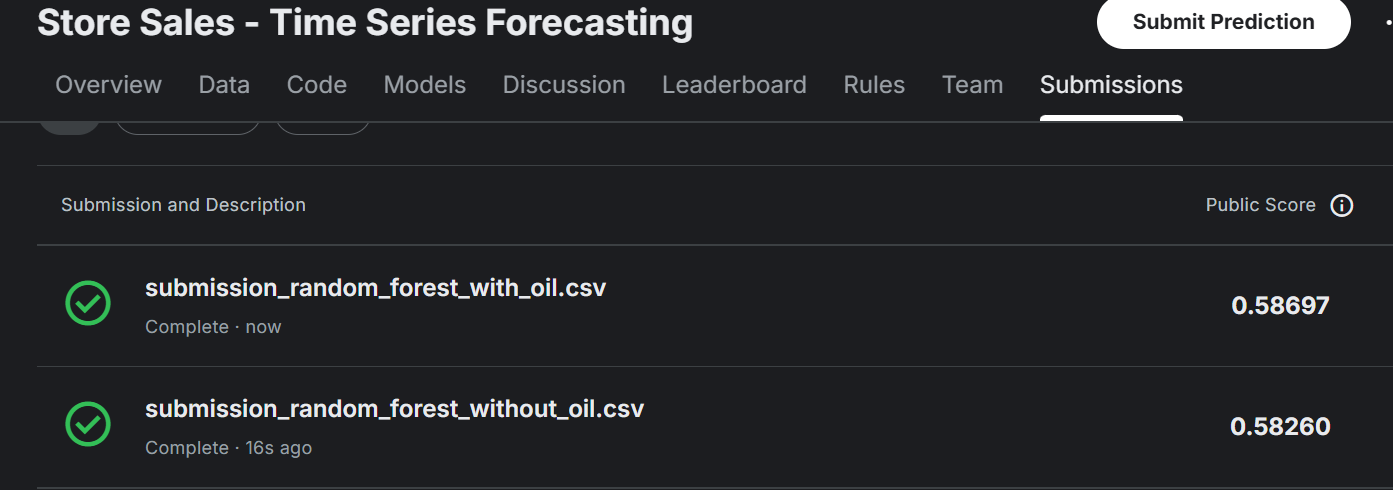